## Load libraries

In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns

## Define functions and constants

In [2]:
def usd_to_ntd(amount):
    return amount * 31.15 # Exchange rate, 2023

def ntd_to_usd(amount):
    return amount / 31.15 # Exchange rate, 2023

def mpg_to_kml(value):
    return  value/2.352

def calculate_residual_value(initial_cost, years_owned, depreciation_rate=0.25):
    # Residual depreciates by same rate every year
    residual = [initial_cost]
    for i in range(years_owned+1):
        residual.append(residual[-1] - depreciation_rate * residual[-1])
    return residual[-1]

def calculate_TCO(vehicle, years, depreciation_rate, subsidy=False):
    IPC = (vehicle.vehicle_cost/(vehicle.VKT*years)) # initial purchase cost
    if subsidy:
        IPC = IPC - vehicle.subsidy
    RV = calculate_residual_value(IPC,years,depreciation_rate) # residual value
    PVF = 1/(1+discount_rate)**np.arange(years+1) # present value factor for N years
    FC = (vehicle.fuel_cost + vehicle.fuel_fee_rate) * PVF / years
    OX = (vehicle.maintenance_and_repair_cost + vehicle.insurance_cost) * PVF / years
    LC = vehicle.labor_cost * PVF / years
    TCO = IPC - RV * PVF[-1] + sum(FC) + sum(OX) + sum(LC)
    return sum(FC), sum(LC), (IPC - RV * PVF[-1]) , sum(OX), TCO

def calcualate_average_TCO(vehicle,catagory):
    results = np.array([calculate_TCO(vehicle[f'{catagory}_low'], years, depreciation_rate),
                        calculate_TCO(vehicle[f'{catagory}_high'], years, depreciation_rate)])
    return results.mean(axis=0), results.std(axis=0)

def aggregate_results(vehicle,catagories,currency):
    results = []
    for catagory in catagories:
        results.append(calcualate_average_TCO(vehicle,catagory))
    results = np.array(results)
    if currency=='NTD':
        results = usd_to_ntd(results)     
    return results

years = 16 # years of ownership

depreciation_rate = 0.25
discount_rate = 0.06

hydrogen_kwh_per_kg = 33.3 #kwh/kg
kg_co2_per_kg_hydrogen = {
    "gray": 10,
    "blue": 4,
    "green": 0.5
}


diesel_kwh_per_liter = 10.6
gasoline_kwh_per_liter = 8.9#9.5

diesel_price_low = 24.5 # NTD/L, price on 2025
diesel_price_high = 29.4 # NTD/L, price on March 14, 2022

gasoline_price_low = 28.8 # NTD/L, 92 price on April 7, 2025 https://www.cpc.com.tw/en/HistoryPrice.aspx?n=3058
gasoline_price_high = 32.3 # NTD/L, 98 price on April 7, 2025 https://www.cpc.com.tw/en/HistoryPrice.aspx?n=3058

fast_charge_price_low = 0.18 # USD/kwh https://weitingchen.co/electric-car-charging-landscape-in-taiwan/
fast_charge_price_high = 0.39 # USD/kwh https://weitingchen.co/electric-car-charging-landscape-in-taiwan/

kg_co2_per_L_gasoline = 0.6+2.32 # produce + consume https://doi-org.libproxy.mit.edu/10.1080/15568318.2025.2490488
kg_co2_per_L_diesel = 3.32
diesel_prod_to_consume_ratio = 0.67/kg_co2_per_L_diesel
gasoline_prod_to_consume_ratio = 0.6/kg_co2_per_L_gasoline

## Define and load Vehicle objects

In [3]:

# Base class for vehicles
@dataclass
class Vehicle:
    VKT: float # Annual Vehicle Kilometers Traveled (km/year)
    fuel_efficiency: float  # in kWh/km
    vehicle_cost: float # total price in $
    labor_cost: float # total price in $
    fuel_cost: float # total price in ($/km)
    maintenance_and_repair_cost: float # total price in $ ($/km)
    insurance_cost: float # total price in ($/km)
    fuel_fee_rate: float # total price in ($/km)
    subsidy: float # total price in ($/km)


In [4]:

def dicts_to_vehicles(data):
    """Convert a dict of plain dicts → Vehicle objects."""
    return {name: Vehicle(**attrs) for name, attrs in data.items()}

for v in ['trucks', 'cars', 'scooters', 'bus', 'trucks_light']:
    with open(f"data/{v}.json", "r") as f:
        data = json.load(f)
    globals()[v] = dicts_to_vehicles(data)   # rebuild and assign to same variable name


## Calculate fuel costs

In [5]:

trucks['diesel_low'].fuel_cost = (ntd_to_usd(diesel_price_low)/diesel_kwh_per_liter) * trucks['diesel_low'].fuel_efficiency
trucks['diesel_high'].fuel_cost = (ntd_to_usd(diesel_price_high)/diesel_kwh_per_liter) * trucks['diesel_high'].fuel_efficiency
trucks['electric_low'].fuel_cost = fast_charge_price_low * trucks['electric_low'].fuel_efficiency
trucks['electric_high'].fuel_cost = fast_charge_price_high * trucks['electric_high'].fuel_efficiency

scooters['gasoline_low'].fuel_cost = (ntd_to_usd(gasoline_price_low)/gasoline_kwh_per_liter) * scooters['gasoline_low'].fuel_efficiency
scooters['gasoline_high'].fuel_cost = (ntd_to_usd(gasoline_price_high)/gasoline_kwh_per_liter) * scooters['gasoline_high'].fuel_efficiency
# Price based on battery swapping or charging
scooters['electric_low'].fuel_cost = 599 * .03 / (6400/12)
scooters['electric_high'].fuel_cost = 799 * .03 / (6400/12)

trucks_light['gasoline_low'].fuel_cost = (ntd_to_usd(gasoline_price_low)/gasoline_kwh_per_liter) * trucks_light['gasoline_low'].fuel_efficiency
trucks_light['gasoline_high'].fuel_cost = (ntd_to_usd(gasoline_price_high)/gasoline_kwh_per_liter) * trucks_light['gasoline_high'].fuel_efficiency
trucks_light['electric_low'].fuel_cost = fast_charge_price_low * trucks_light['electric_low'].fuel_efficiency
trucks_light['electric_high'].fuel_cost = fast_charge_price_high * trucks_light['electric_high'].fuel_efficiency

bus['diesel_low'].fuel_cost = (ntd_to_usd(diesel_price_low)/diesel_kwh_per_liter) * bus['diesel_low'].fuel_efficiency
bus['diesel_high'].fuel_cost = (ntd_to_usd(diesel_price_high)/diesel_kwh_per_liter) * bus['diesel_high'].fuel_efficiency
bus['electric_low'].fuel_cost = fast_charge_price_low * bus['electric_low'].fuel_efficiency
bus['electric_high'].fuel_cost = fast_charge_price_high * bus['electric_high'].fuel_efficiency

cars['gasoline_low'].fuel_cost = (ntd_to_usd(gasoline_price_low)/gasoline_kwh_per_liter) * cars['gasoline_low'].fuel_efficiency
cars['gasoline_high'].fuel_cost = (ntd_to_usd(gasoline_price_high)/gasoline_kwh_per_liter) * cars['gasoline_high'].fuel_efficiency
cars['hybrid_low'].fuel_cost = (ntd_to_usd(gasoline_price_low)/gasoline_kwh_per_liter) * cars['hybrid_low'].fuel_efficiency
cars['hybrid_high'].fuel_cost = (ntd_to_usd(gasoline_price_high)/gasoline_kwh_per_liter) * cars['hybrid_high'].fuel_efficiency
cars['electric_low'].fuel_cost = fast_charge_price_low * cars['electric_low'].fuel_efficiency
cars['electric_high'].fuel_cost = fast_charge_price_high * cars['electric_high'].fuel_efficiency
cars['phev_low'].fuel_cost = 0.5*cars['gasoline_low'].fuel_cost  + 0.5* cars['electric_low'].fuel_cost 
cars['phev_high'].fuel_cost = 0.5*cars['gasoline_high'].fuel_cost  + 0.5* cars['electric_high'].fuel_cost 


## Add battery replacement cost to M&R

In [6]:
cost_battery_kwh = 90-(23+31)/2 
trucks['electric_low'].maintenance_and_repair_cost = trucks['electric_low'].maintenance_and_repair_cost + cost_battery_kwh*732/(trucks['electric_low'].VKT*16)
trucks['electric_high'].maintenance_and_repair_cost = trucks['electric_high'].maintenance_and_repair_cost + cost_battery_kwh*732/(trucks['electric_high'].VKT*16)
trucks['hydrogen_low'].maintenance_and_repair_cost = trucks['hydrogen_low'].maintenance_and_repair_cost + cost_battery_kwh*285/(trucks['hydrogen_low'].VKT*16)
trucks['hydrogen_high'].maintenance_and_repair_cost = trucks['hydrogen_high'].maintenance_and_repair_cost + cost_battery_kwh*285/(trucks['hydrogen_high'].VKT*16)

bus['electric_low'].maintenance_and_repair_cost = bus['electric_low'].maintenance_and_repair_cost + cost_battery_kwh*324/(bus['electric_low'].VKT*16)
bus['electric_high'].maintenance_and_repair_cost = bus['electric_high'].maintenance_and_repair_cost + cost_battery_kwh*324/(bus['electric_high'].VKT*16)

cars['electric_low'].maintenance_and_repair_cost = cars['electric_low'].maintenance_and_repair_cost + cost_battery_kwh*26/(cars['electric_low'].VKT*16)
cars['electric_high'].maintenance_and_repair_cost = cars['electric_high'].maintenance_and_repair_cost + cost_battery_kwh*26/(cars['electric_high'].VKT*16)
cars['hybrid_low'].maintenance_and_repair_cost = cars['hybrid_low'].maintenance_and_repair_cost + cost_battery_kwh*1.6/(cars['hybrid_low'].VKT*16)
cars['hybrid_high'].maintenance_and_repair_cost = cars['hybrid_high'].maintenance_and_repair_cost + cost_battery_kwh*1.6/(cars['hybrid_high'].VKT*16)
cars['phev_low'].maintenance_and_repair_cost = cars['phev_low'].maintenance_and_repair_cost + cost_battery_kwh*17/(cars['phev_low'].VKT*16)
cars['phev_high'].maintenance_and_repair_cost = cars['phev_high'].maintenance_and_repair_cost + cost_battery_kwh*17/(cars['phev_high'].VKT*16)

# Included in Gogoro subscription / don't count twice
# Scooters['electric_low'].maintenance_and_repair_cost = Scooters['electric_low'].maintenance_and_repair_cost + cost_battery_kwh*1.3/(Scooters['electric_low'].VKT*16)
# Scooters['electric_high'].maintenance_and_repair_cost = Scooters['electric_high'].maintenance_and_repair_cost + cost_battery_kwh*1.3/(Scooters['electric_high'].VKT*16)

trucks_light['electric_low'].maintenance_and_repair_cost = trucks_light['electric_low'].maintenance_and_repair_cost + cost_battery_kwh*31/(trucks_light['electric_low'].VKT*16)
trucks_light['electric_high'].maintenance_and_repair_cost = trucks_light['electric_high'].maintenance_and_repair_cost + cost_battery_kwh*31/(trucks_light['electric_high'].VKT*16)

## Define vehicle emissions

In [7]:
vehicle_types = [
    "trucks - diesel", "trucks - electric", "trucks - hydrogen",
    "cars - gasoline", "cars - hybrid", "cars - phev", "cars - electric",
    "trucks_light - gasoline", "trucks_light - electric",
    "bus - diesel", "bus - electric",
    "scooters - gasoline", "scooters - electric"
]

vehicle_types = np.array(vehicle_types)


emissions_vehicle_producion = [
    56110, 168400*(0.33)+732*61, 70150,
    8000, 10400, 12000, 13600,
    9980, 16170,
    37459, 50297,
    260, 401
] 

emissions_battery_replacement = [
    0, 732*61, 285*61,
    0, 1.6*61, 17*61, 26*61,
    0, 31*61,
    0, 324*69, # LFP
    0, 79.3
] 


emissions_kg = np.array(emissions_vehicle_producion) + np.array(emissions_battery_replacement)

# Pairs: (electric, conventional)
pairs = [
    ("trucks - electric", "trucks - diesel"),
    ("cars - electric", "cars - gasoline"),
    ("trucks_light - electric", "trucks_light - gasoline"),
    ("bus - electric", "bus - diesel"),
    ("scooters - electric", "scooters - gasoline"),
]

print("Electric / Conventional Production Emission Ratios:\n")
for e, c in pairs:
    e_val = emissions_kg[vehicle_types == e][0]
    c_val = emissions_kg[vehicle_types == c][0]
    ratio = e_val / c_val
    print(f"{e} vs {c}: {e_val:.0f} / {c_val:.0f} = {ratio:.2f}x")

Electric / Conventional Production Emission Ratios:

trucks - electric vs trucks - diesel: 144876 / 56110 = 2.58x
cars - electric vs cars - gasoline: 15186 / 8000 = 1.90x
trucks_light - electric vs trucks_light - gasoline: 18061 / 9980 = 1.81x
bus - electric vs bus - diesel: 72653 / 37459 = 1.94x
scooters - electric vs scooters - gasoline: 480 / 260 = 1.85x


## Calculate and plot LCE

Mode         Switch               % Reduction
---------------------------------------------
Trucks       Electric (2025)             9.9
Trucks       Electric (2050)            58.8
Trucks       Green H₂                   82.3
Cars         Electric (2025)            41.1
Cars         Electric (2050)            62.0
LightTrucks  Electric (2025)            34.4
LightTrucks  Electric (2050)            67.5
Buses        Electric (2025)            30.8
Buses        Electric (2050)            75.8
Scooters     Electric (2025)            66.2
Scooters     Electric (2050)            85.2


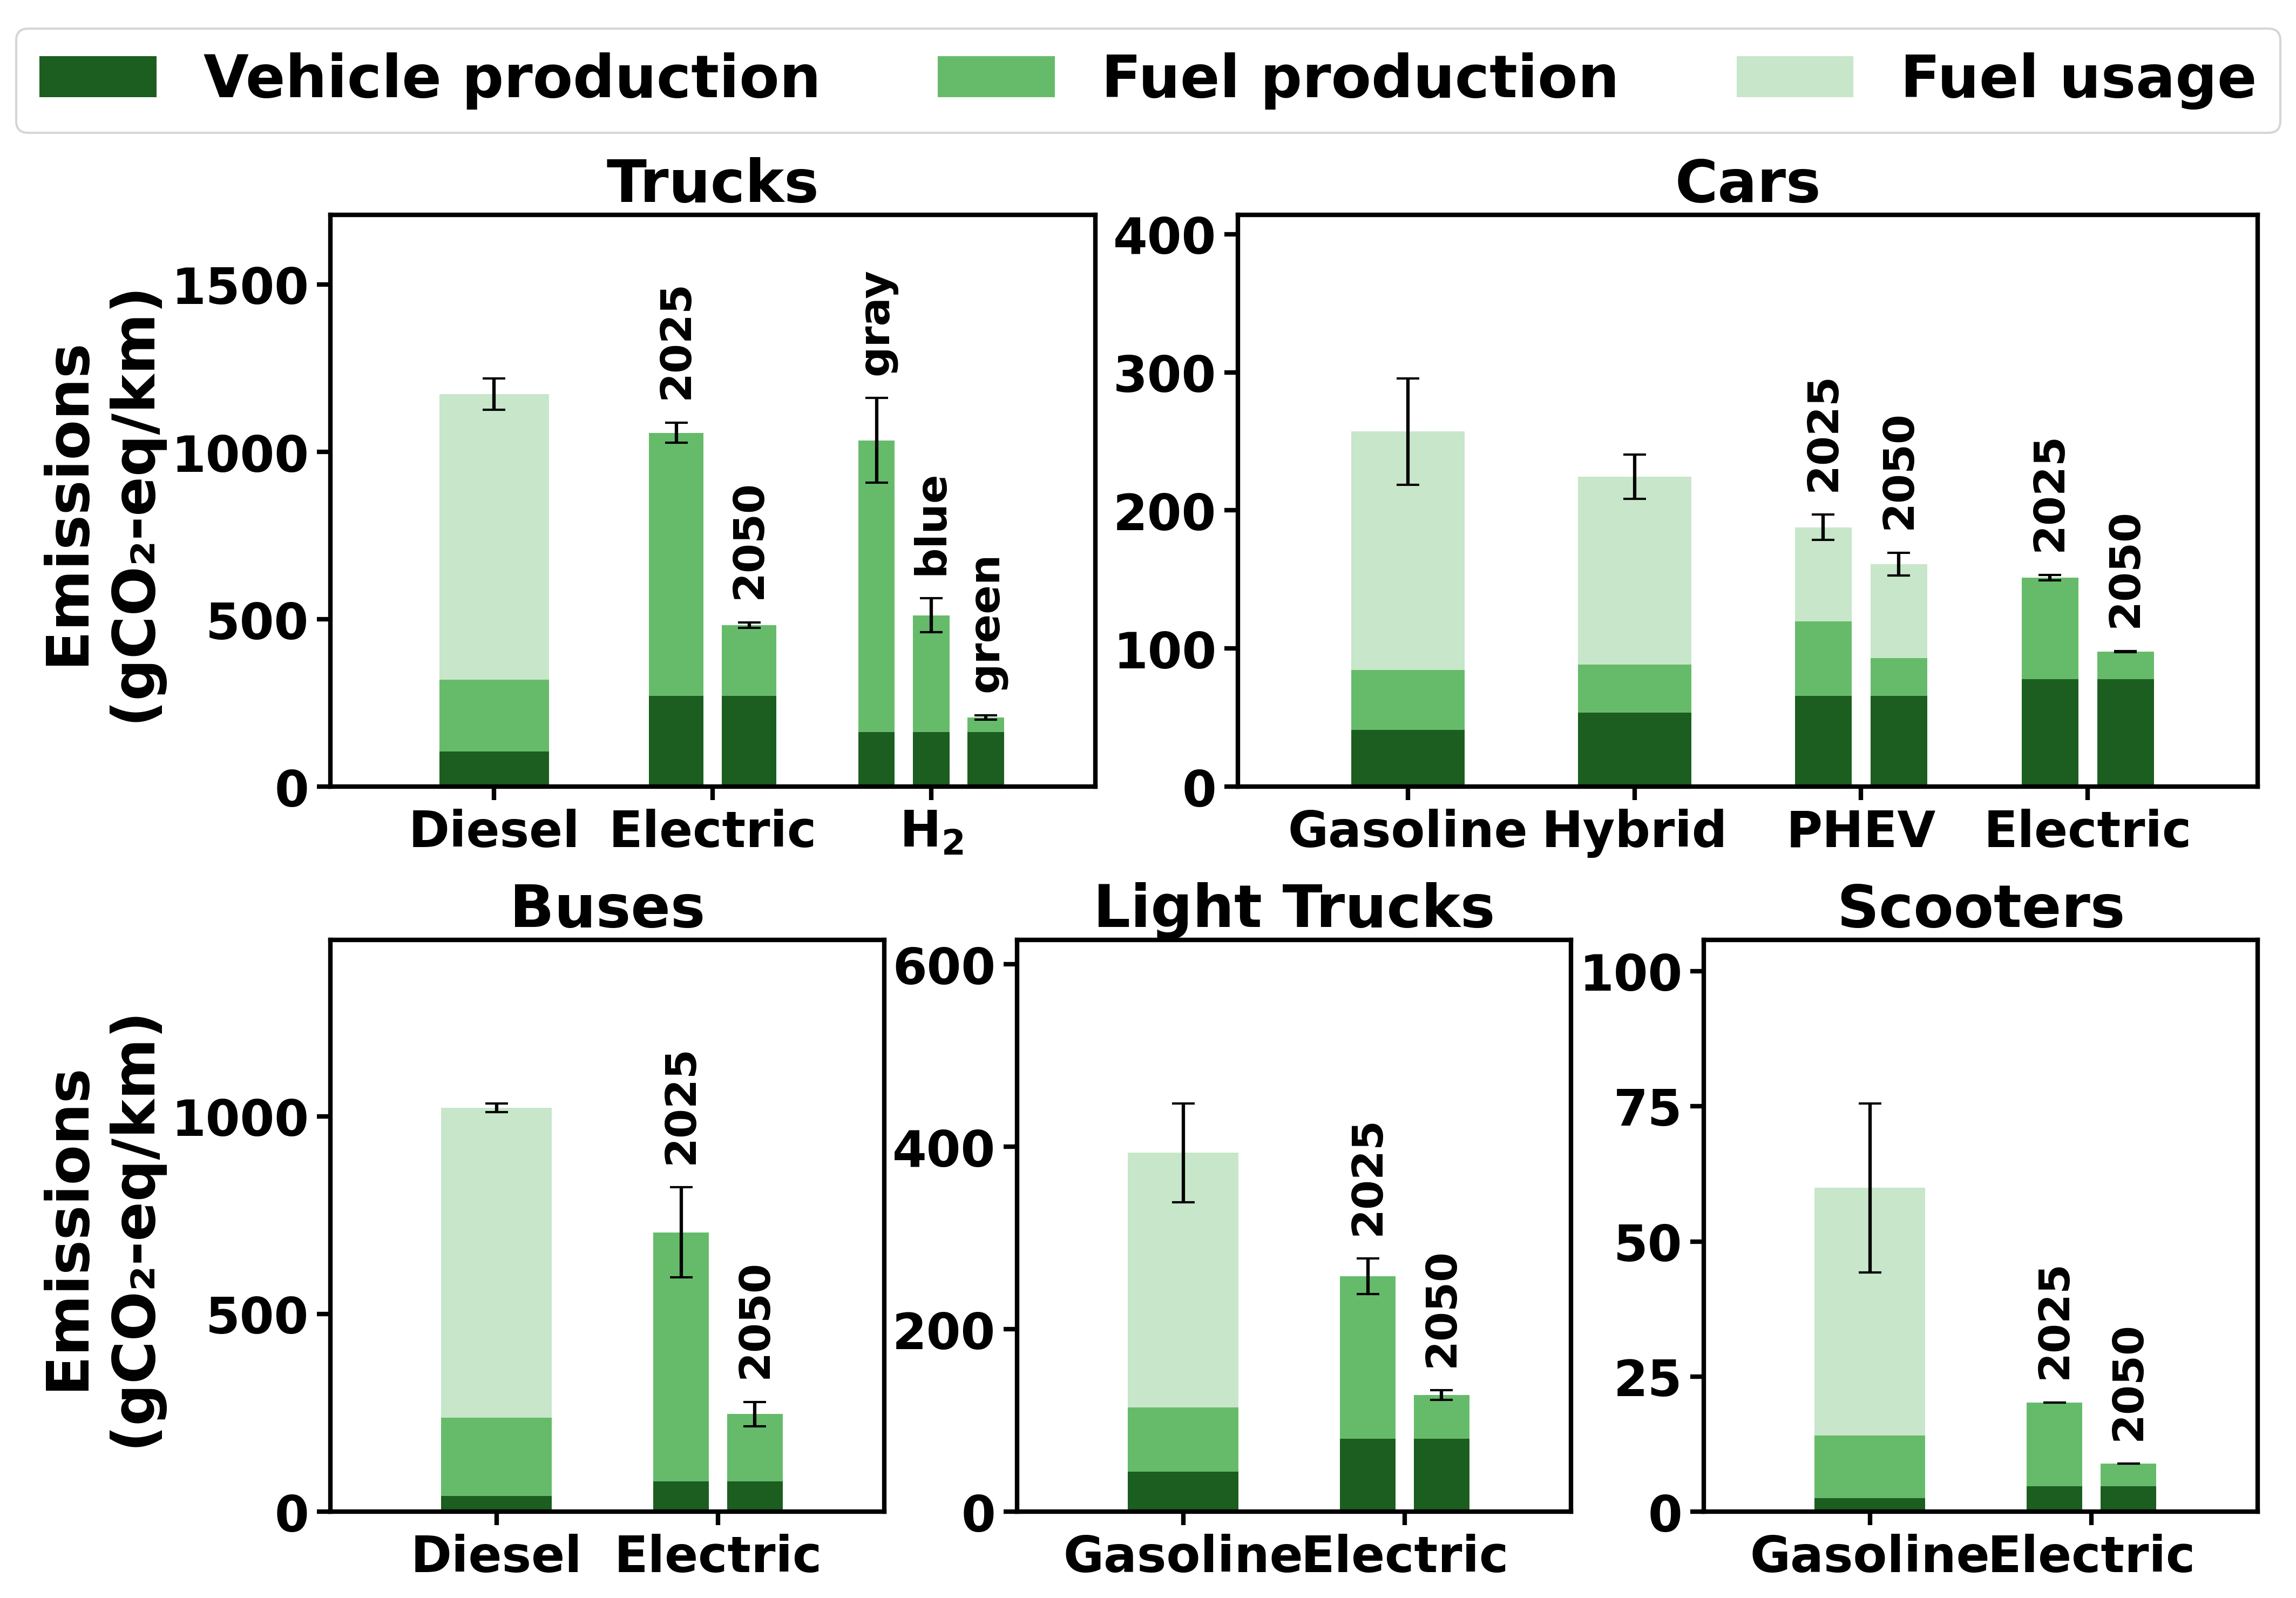

In [8]:

plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'axes.linewidth': 2,
})

year=np.arange(2020,2051);
Grid_intensity= 5.2*(10**45)*np.exp(-0.0524*year)

def calculate_emission_intensity(vehicle_data, fuel_type, year_i=2025, h2_type=None):
    low_eff = vehicle_data[f'{fuel_type}_low'].fuel_efficiency
    high_eff = vehicle_data[f'{fuel_type}_high'].fuel_efficiency
    
    if fuel_type=='electric':
        ei_low = Grid_intensity[year==year_i][0] * high_eff
        ei_high = Grid_intensity[year==year_i][0] * low_eff
    else:
        if fuel_type=='hydrogen':
            kwh_per = hydrogen_kwh_per_kg
            kg_co2 = kg_co2_per_kg_hydrogen[h2_type]
        elif 'diesel' in fuel_type:
            kwh_per = diesel_kwh_per_liter
            kg_co2 = kg_co2_per_L_diesel
        else:
            kwh_per = gasoline_kwh_per_liter
            kg_co2 = kg_co2_per_L_gasoline
        
        ei_low = low_eff / kwh_per * kg_co2
        ei_high = high_eff / kwh_per * kg_co2
        
    ei_avg = (ei_low + ei_high) / 2
    return ei_low, ei_avg, ei_high

def calculate_emission(vehicle_data, fuel_type, year_i=2025, h2_type=None):
    v_prod = emissions_kg[np.where(vehicle_types==str(vehicle_data)+" - "+fuel_type)[0][0]]
    for v in [vehicle_data]:
        with open(f"data/{v}.json", "r") as f:
            data = json.load(f)
        vehicle_data = dicts_to_vehicles(data)   # rebuild and assign to same variable name
    vkt = vehicle_data[f'{fuel_type}_low'].VKT
    ei_low, ei_avg, ei_high = calculate_emission_intensity(vehicle_data, fuel_type, year_i=year_i, h2_type=h2_type)
    if fuel_type=='electric':
        e_prod = ei_avg
        e_con = 0
    elif fuel_type=='hydrogen':
        e_prod = ei_avg
        e_con = 0
    else:
            if 'diesel' in fuel_type:
                e_prod = diesel_prod_to_consume_ratio * ei_avg
                e_con = (1-diesel_prod_to_consume_ratio) * ei_avg
            else:
                e_prod = diesel_prod_to_consume_ratio * ei_avg
                e_con = (1-diesel_prod_to_consume_ratio) * ei_avg
    error = (ei_high-ei_low)/2 
    
    return (v_prod*1000)/(16*vkt), e_prod*1000, e_con*1000, np.abs(error)*1000


truck_categories = ['Diesel', 'Electric', 'H$_2$']
truck_emissions = [
    [*calculate_emission('trucks','diesel')],
    [*calculate_emission('trucks','electric',year_i=2025),
     *calculate_emission('trucks','electric',year_i=2050)],
    [*calculate_emission('trucks','hydrogen',h2_type='gray'),
     *calculate_emission('trucks','hydrogen',h2_type='blue'),
     *calculate_emission('trucks','hydrogen',h2_type='green')]
]

car_categories = ['Gasoline', 'Hybrid', 'PHEV', 'Electric']
car_emissions = [
    [*calculate_emission('cars','gasoline')],
    [*calculate_emission('cars','hybrid')],
    [*(np.array(calculate_emission('cars','hybrid'))+np.array(calculate_emission('cars','electric')))/2,
     *(np.array(calculate_emission('cars','hybrid'))+np.array(calculate_emission('cars','electric',year_i=2050)))/2],
    [*calculate_emission('cars','electric',year_i=2025),
     *calculate_emission('cars','electric',year_i=2050)]
]

light_truck_categories = ['Gasoline', 'Electric']
light_truck_emissions = [
    [*calculate_emission('trucks_light','gasoline')],
    [*calculate_emission('trucks_light','electric',year_i=2025),
     *calculate_emission('trucks_light','electric',year_i=2050)]
]

bus_categories = ['Diesel', 'Electric']
bus_emissions = [
    [*calculate_emission('bus','diesel')],
    [*calculate_emission('bus','electric',year_i=2025),
     *calculate_emission('bus','electric',year_i=2050)]
]

scooter_categories = ['Gasoline', 'Electric']
scooter_emissions = [
    [*calculate_emission('scooters','gasoline')],
    [*calculate_emission('scooters','electric',year_i=2025),
     *calculate_emission('scooters','electric',year_i=2050)]
]

# --- Plot setup ---
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[3, 4], wspace=.16)
ax_truck = fig.add_subplot(gs_top[0])
ax_car = fig.add_subplot(gs_top[1])

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[2, 2, 2], wspace=.24)
ax_bus = fig.add_subplot(gs_bottom[0])
ax_lt = fig.add_subplot(gs_bottom[1])
ax_scooter = fig.add_subplot(gs_bottom[2])

def emissions_bar(ax, categories, emissions_data, title, ylabel=True):
    x = np.arange(len(categories))
    width = 0.5
    elec_width = width / 2
    h2_width = width / 3
    ymax = 0  # Track max height for y-limit

    for i, (cat, em) in enumerate(zip(categories, emissions_data)):
        if len(em) == 4:
            v, fp, fu, err = em
            total = v + fp + fu
            ymax = max(ymax, total+err)
            ax.bar(i, v, width, color='#1B5E20')
            ax.bar(i, fp, width, bottom=v, color='#66BB6A')
            ax.bar(i, fu, width, bottom=v+fp, yerr=err, capsize=5, color='#C8E6C9')
        elif len(em) == 8:
            v25, fp25, fu25, err25, v50, fp50, fu50, err50 = em
            total_25 = v25 + fp25 + fu25
            total_50 = v50 + fp50 + fu50
            ymax = max(ymax, total_25+err25, total_50+err50)
            
            # 2025 bars
            ax.bar(i - elec_width/1.5, v25, elec_width, color='#1B5E20')
            ax.bar(i - elec_width/1.5, fp25, elec_width, bottom=v25, color='#66BB6A')
            ax.bar(i - elec_width/1.5, fu25, elec_width, bottom=v25+fp25, yerr=err25, capsize=5, color='#C8E6C9')
            ax.text(i - elec_width/1.5, total_25 + err25 + ymax*0.08, '2025', ha='center', fontsize=19, fontweight='bold',rotation=90)

            # 2050 bars
            ax.bar(i + elec_width/1.5, v50, elec_width, color='#1B5E20')
            ax.bar(i + elec_width/1.5, fp50, elec_width, bottom=v50, color='#66BB6A')
            ax.bar(i + elec_width/1.5, fu50, elec_width, bottom=v50+fp50, yerr=err50, capsize=5, color='#C8E6C9')
            ax.text(i + elec_width/1.5, total_50 + err50 + ymax*0.08, '2050', ha='center', fontsize=19, fontweight='bold',rotation=90)
        else:
            vgray, fpgray, fugray, errgray, vblue, fpblue, fublue, errblue, vgreen, fpgreen, fugreen, errgreen  = em
            total_gray = vgray + fpgray + fugray
            total_blue = vblue + fpblue + fublue
            total_green = vgreen + fpgreen + fugreen
            ymax = max(ymax, total_gray+errgray, total_blue+errblue, total_green+errgreen)
            
            # gray bars
            ax.bar(i - elec_width, vgray, h2_width, color='#1B5E20')
            ax.bar(i - elec_width, fpgray, h2_width, bottom=vgray, color='#66BB6A')
            ax.bar(i - elec_width, fugray, h2_width, bottom=vgray+fpgray, yerr=errgray, capsize=5, color='#C8E6C9')
            ax.text(i - elec_width, total_gray + errgray + ymax*0.08, 'gray', ha='center', fontsize=19, fontweight='bold',rotation=90)

            # blue bars
            ax.bar(i , vblue, h2_width, color='#1B5E20')
            ax.bar(i , fpblue, h2_width, bottom=vblue, color='#66BB6A')
            ax.bar(i , fublue, h2_width, bottom=vblue+fpblue, yerr=errblue, capsize=5, color='#C8E6C9')
            ax.text(i , total_blue + errblue +  ymax*0.08, 'blue', ha='center', fontsize=19, fontweight='bold',rotation=90)
            
            # green bars
            ax.bar(i + elec_width, vgreen, h2_width, color='#1B5E20')
            ax.bar(i + elec_width, fpgreen, h2_width, bottom=vgreen, color='#66BB6A')
            ax.bar(i + elec_width, fugreen, h2_width, bottom=vgreen+fpgreen, yerr=errgreen, capsize=5, color='#C8E6C9')
            ax.text(i + elec_width, total_green + errgreen + ymax*0.08, 'green', ha='center', fontsize=19, fontweight='bold',rotation=90)

    # Axis styling updates:
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=22, fontweight='bold')
    ax.set_title(title, fontsize=26, fontweight='bold')
    if ylabel:
        ax.set_ylabel("Emissions\n(gCO₂-eq/km)", fontsize=26, fontweight='bold')
    ax.set_xlim(-0.75, len(categories) - 0.25)
    ax.set_ylim(0, ymax * 1.4)
    ax.set_xticklabels(categories, fontsize=22, fontweight='bold')

    # Make ticks and borders thicker
    ax.tick_params(width=2, length=6, labelsize=22)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

legend_elements = [
    Patch(facecolor='#1B5E20', label='Vehicle production'),
    Patch(facecolor='#66BB6A', label='Fuel production'),
    Patch(facecolor='#C8E6C9', label='Fuel usage'),
]        
        
fig.legend(handles=legend_elements, loc='upper center', fontsize=26, ncol=3, frameon=True)
for text in fig.legends[0].get_texts():
    text.set_fontweight('bold')

    
emissions_bar(ax_truck, truck_categories, truck_emissions, "Trucks")
emissions_bar(ax_car, car_categories, car_emissions, "Cars", ylabel=False)
emissions_bar(ax_bus, bus_categories, bus_emissions, "Buses")
emissions_bar(ax_lt, light_truck_categories, light_truck_emissions, "Light Trucks", ylabel=False)
emissions_bar(ax_scooter, scooter_categories, scooter_emissions, "Scooters", ylabel=False)
# # --- Custom Legend ---
# legend_elements = [
#     Patch(facecolor='#1B5E20', label='Vehicle production emissions'),
#     Patch(facecolor='#66BB6A', label='Fuel production emissions'),
#     Patch(facecolor='#C8E6C9', label='Fuel usage emissions'),
# ]
# fig.legend(handles=legend_elements, loc='upper center', fontsize=26, ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.91])
# plt.show()
plt.savefig("figs/LCE.png", format='png')


def summarize_all():
    def total_emission(em):
        return sum(em[:3])  # vehicle + fuel prod + fuel use
    
    def pct_reduction(baseline, new):
        return 100 * (1 - new / baseline)
    
    print("{:<12} {:<20} {:>10}".format("Mode", "Switch", "% Reduction"))
    print("-"*45)
    
    # ---- Trucks ----
    em_truck = dict(zip(truck_categories, truck_emissions))
    baseline = total_emission(em_truck["Diesel"])
    # Electric 2025
    total25 = sum(em_truck["Electric"][:3])
    print("{:<12} {:<20} {:>10.1f}".format("Trucks", "Electric (2025)", pct_reduction(baseline, total25)))
    # Electric 2050
    total50 = sum(em_truck["Electric"][4:7])
    print("{:<12} {:<20} {:>10.1f}".format("Trucks", "Electric (2050)", pct_reduction(baseline, total50)))
    # Green H2
    total_h2 = sum(em_truck["H$_2$"][8:11])  # green = 3rd set
    print("{:<12} {:<20} {:>10.1f}".format("Trucks", "Green H₂", pct_reduction(baseline, total_h2)))
    
    # ---- Cars ----
    em_car = dict(zip(car_categories, car_emissions))
    baseline = total_emission(em_car["Gasoline"])
    total25 = sum(em_car["Electric"][:3])
    total50 = sum(em_car["Electric"][4:7])
    print("{:<12} {:<20} {:>10.1f}".format("Cars", "Electric (2025)", pct_reduction(baseline, total25)))
    print("{:<12} {:<20} {:>10.1f}".format("Cars", "Electric (2050)", pct_reduction(baseline, total50)))
    
    # ---- Light Trucks ----
    em_lt = dict(zip(light_truck_categories, light_truck_emissions))
    baseline = total_emission(em_lt["Gasoline"])
    total25 = sum(em_lt["Electric"][:3])
    total50 = sum(em_lt["Electric"][4:7])
    print("{:<12} {:<20} {:>10.1f}".format("LightTrucks", "Electric (2025)", pct_reduction(baseline, total25)))
    print("{:<12} {:<20} {:>10.1f}".format("LightTrucks", "Electric (2050)", pct_reduction(baseline, total50)))
    
    # ---- Buses ----
    em_bus = dict(zip(bus_categories, bus_emissions))
    baseline = total_emission(em_bus["Diesel"])
    total25 = sum(em_bus["Electric"][:3])
    total50 = sum(em_bus["Electric"][4:7])
    print("{:<12} {:<20} {:>10.1f}".format("Buses", "Electric (2025)", pct_reduction(baseline, total25)))
    print("{:<12} {:<20} {:>10.1f}".format("Buses", "Electric (2050)", pct_reduction(baseline, total50)))
    
    # ---- Scooters ----
    em_scooter = dict(zip(scooter_categories, scooter_emissions))
    baseline = total_emission(em_scooter["Gasoline"])
    total25 = sum(em_scooter["Electric"][:3])
    total50 = sum(em_scooter["Electric"][4:7])
    print("{:<12} {:<20} {:>10.1f}".format("Scooters", "Electric (2025)", pct_reduction(baseline, total25)))
    print("{:<12} {:<20} {:>10.1f}".format("Scooters", "Electric (2050)", pct_reduction(baseline, total50)))

# --- Run it ---
summarize_all()


## Calculate and plot TCO

/tmp/ipykernel_40446/75998371.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_truck.set_xticklabels(labels_truck, fontsize=22, fontweight='bold')


Ratio of TCO (Electric / Conventional):

Trucks (Electric/Diesel): 1.30
Cars (Electric/Gasoline): 1.28
Light Trucks (Electric/Gasoline): 1.17
Buses (Electric/Diesel): 1.41
Scooters (Electric/Gasoline): 1.44


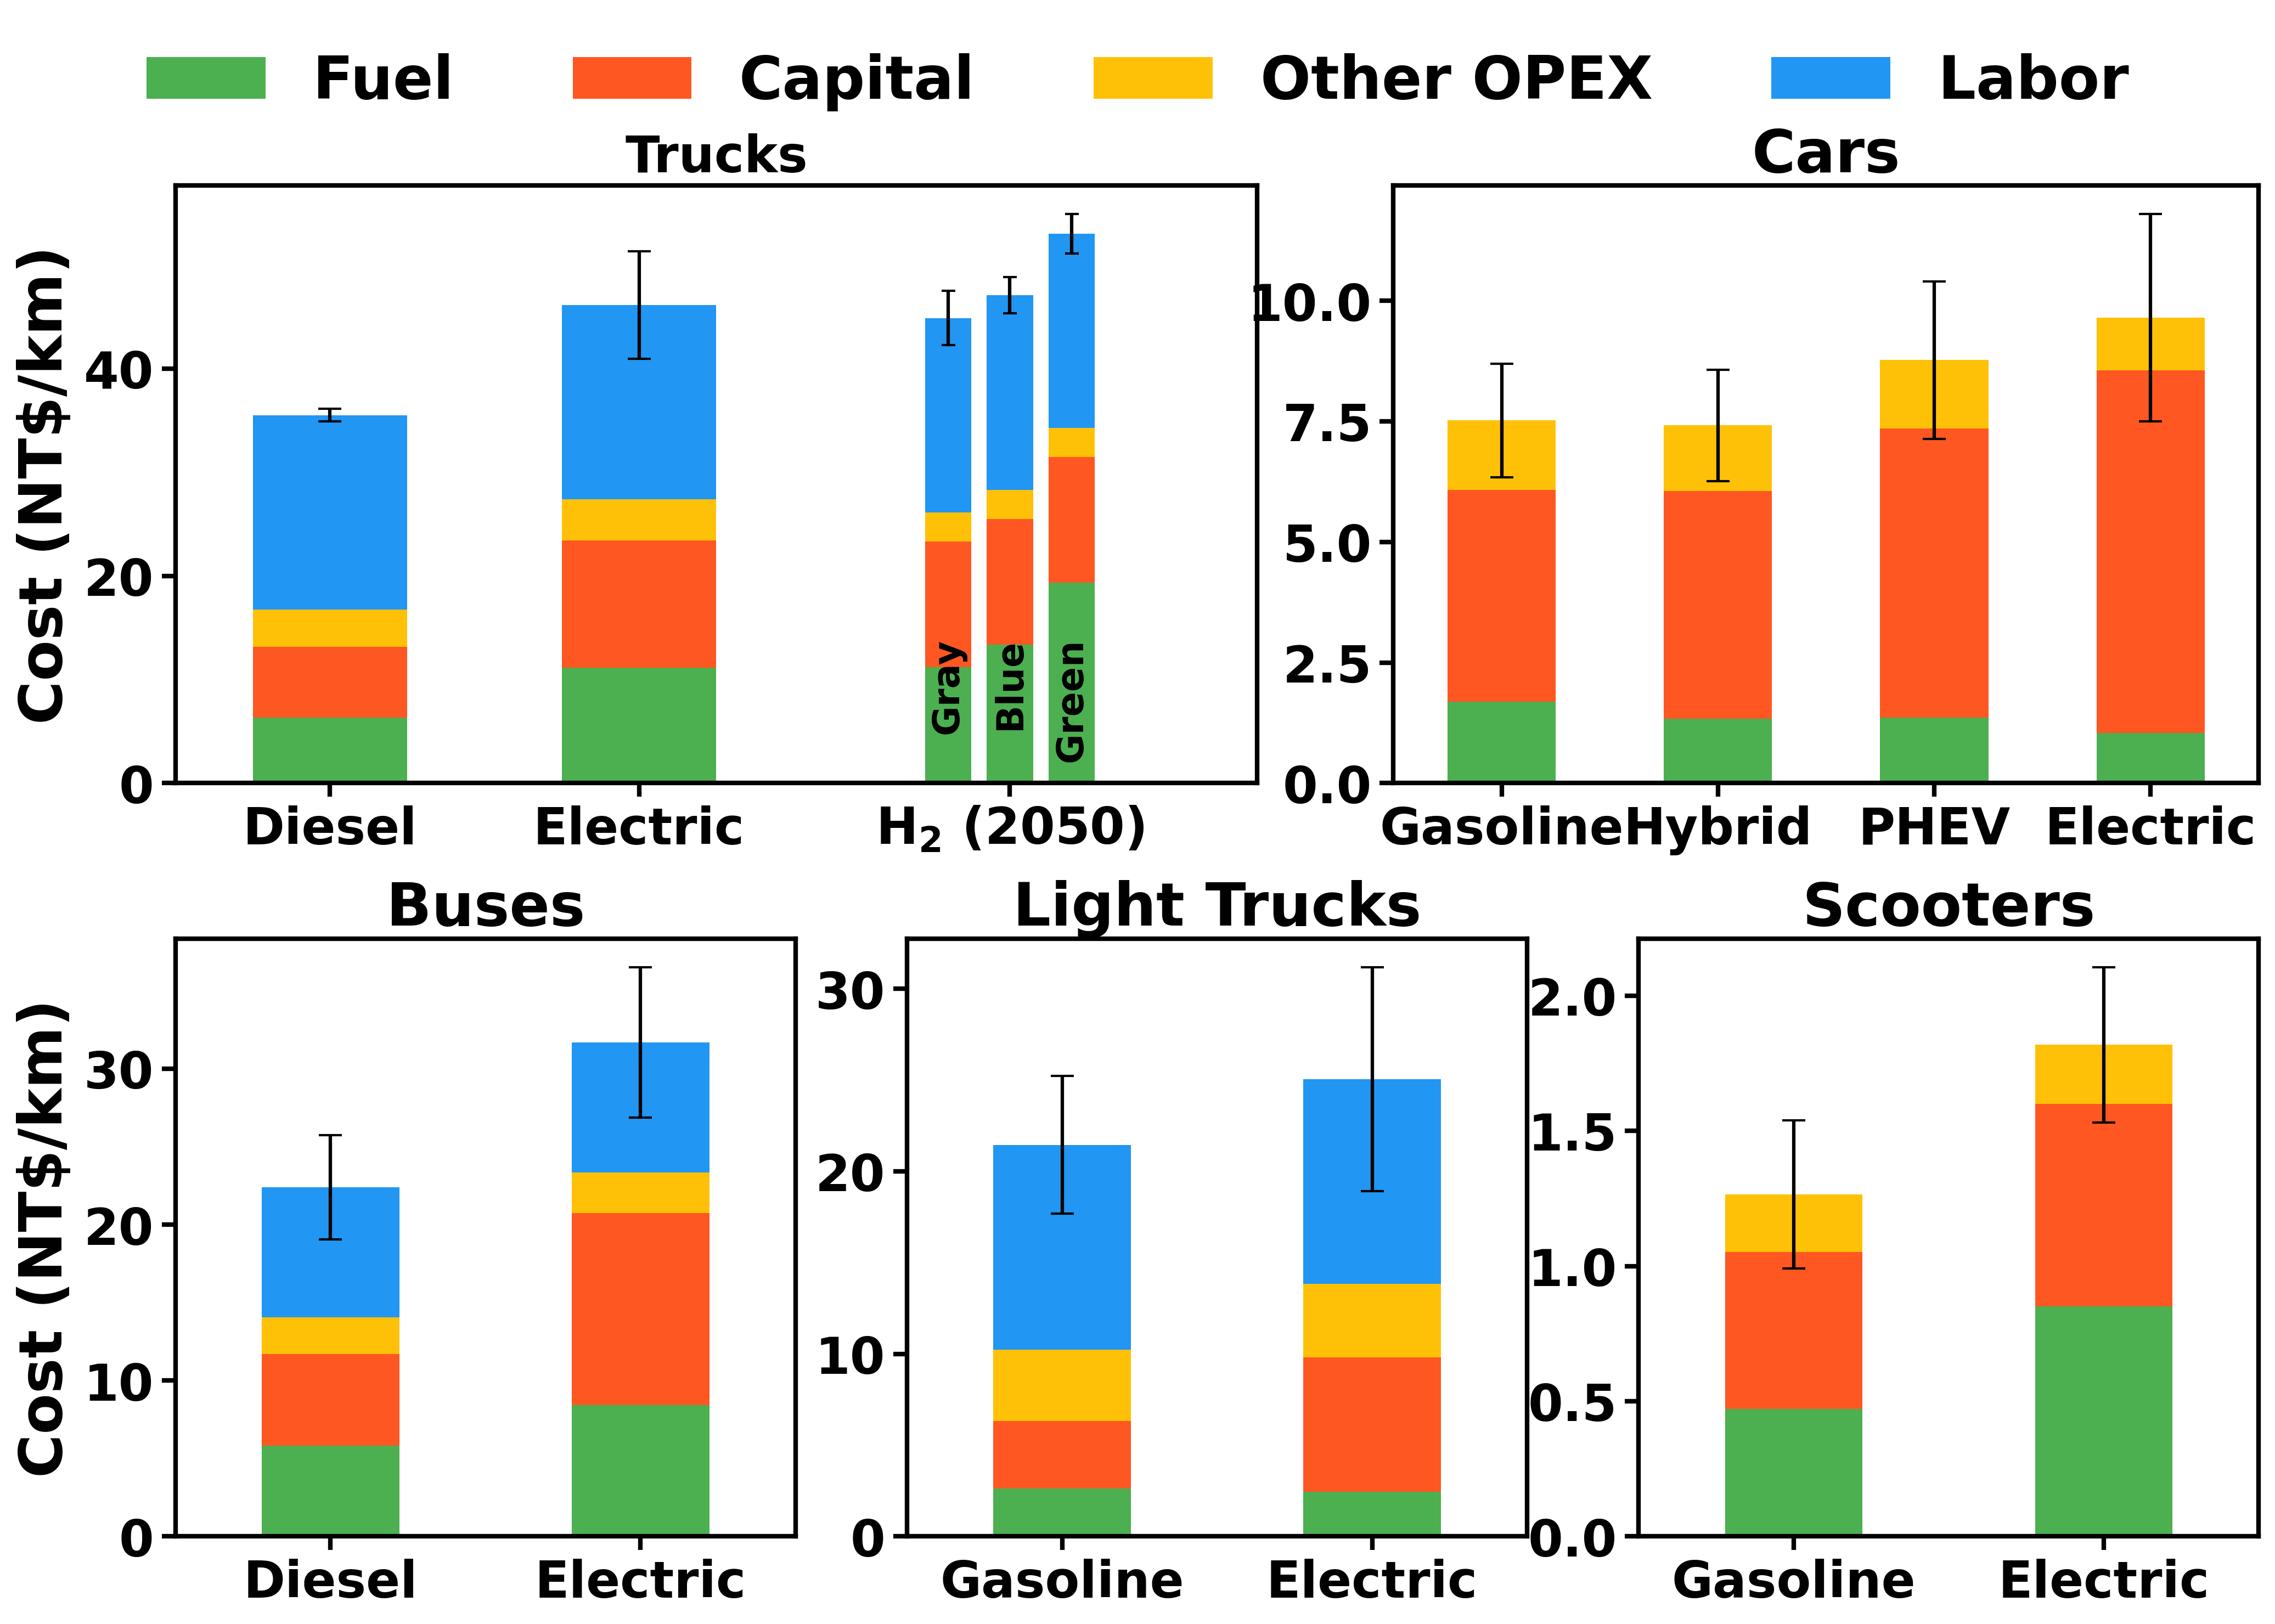

In [9]:

truck_categories = ['Diesel', 'Electric', 'Hydrogen']
car_categories = ['Gasoline', 'Hybrid', 'PHEV', 'Electric']
light_truck_categories = ['Gasoline', 'Electric']
bus_categories = ['Diesel', 'Electric']
scooter_categories = ['Gasoline', 'Electric']


# Truck data
dispense_cost_low  = 5
dispense_cost_high = 5
trucks['hydrogen_low'].fuel_cost = (dispense_cost_low+0.9) * trucks['hydrogen_low'].fuel_efficiency/hydrogen_kwh_per_kg
trucks['hydrogen_high'].fuel_cost = (dispense_cost_high+1) * trucks['hydrogen_high'].fuel_efficiency/hydrogen_kwh_per_kg
hydrogen_data_gray = aggregate_results(trucks,['hydrogen'],'NTD')
trucks['hydrogen_low'].fuel_cost = (dispense_cost_low+1.5) * trucks['hydrogen_low'].fuel_efficiency/hydrogen_kwh_per_kg
trucks['hydrogen_high'].fuel_cost = (dispense_cost_high+2.9) * trucks['hydrogen_high'].fuel_efficiency/hydrogen_kwh_per_kg
hydrogen_data_blue = aggregate_results(trucks,['hydrogen'],'NTD')
trucks['hydrogen_low'].fuel_cost = (dispense_cost_low+3.6) * trucks['hydrogen_low'].fuel_efficiency/hydrogen_kwh_per_kg
trucks['hydrogen_high'].fuel_cost = (dispense_cost_high+7.5) * trucks['hydrogen_high'].fuel_efficiency/hydrogen_kwh_per_kg
hydrogen_data_green = aggregate_results(trucks,['hydrogen'],'NTD')

# Truck data
truck_results = aggregate_results(trucks,['diesel','electric','hydrogen'],'NTD')
electricity_truck = truck_results[:,0,0]
labor_truck = truck_results[:,0,1]
capital_truck = truck_results[:,0,2]
opex_truck = truck_results[:,0,3]
electricity_error_truck = truck_results[:,1,0]
labor_error_truck = truck_results[:,1,1]
capital_error_truck = truck_results[:,1,2]
opex_error_truck = truck_results[:,1,3]

# Car data
car_results = aggregate_results(cars,['gasoline','hybrid','phev','electric'],'NTD')
electricity_car = car_results[:,0,0]
labor_car = car_results[:,0,1]
capital_car = car_results[:,0,2]
opex_car = car_results[:,0,3]
electricity_error_car = car_results[:,1,0]
labor_error_car = car_results[:,1,1]
capital_error_car = car_results[:,1,2]
opex_error_car = car_results[:,1,3]

# Light Truck data
trucks_light_results = aggregate_results(trucks_light,['gasoline','electric'],'NTD')
electricity_light_truck = trucks_light_results[:,0,0]
labor_light_truck = trucks_light_results[:,0,1]
capital_light_truck = trucks_light_results[:,0,2]
opex_light_truck = trucks_light_results[:,0,3]
electricity_error_light_truck = trucks_light_results[:,1,0]
labor_error_light_truck = trucks_light_results[:,1,1]
capital_error_light_truck = trucks_light_results[:,1,2]
opex_error_light_truck = trucks_light_results[:,1,3]

# Bus data
bus_results = aggregate_results(bus,['diesel','electric'],'NTD')
electricity_bus = bus_results[:,0,0]
labor_bus = bus_results[:,0,1]
capital_bus = bus_results[:,0,2]
opex_bus = bus_results[:,0,3]
electricity_error_bus = bus_results[:,1,0]
labor_error_bus = bus_results[:,1,1]
capital_error_bus = bus_results[:,1,2]
opex_error_bus = bus_results[:,1,3]

# Scooter data
scooter_results = aggregate_results(scooters,['gasoline','electric'],'NTD')
electricity_scooter = scooter_results[:,0,0]
labor_scooter = scooter_results[:,0,1]
capital_scooter = scooter_results[:,0,2]
opex_scooter = scooter_results[:,0,3]
electricity_error_scooter = scooter_results[:,1,0]
labor_error_scooter = scooter_results[:,1,1]
capital_error_scooter = scooter_results[:,1,2]
opex_error_scooter = scooter_results[:,1,3]

# Truck data split
diesel_data = truck_results[0]
electric_data = truck_results[1]
hydrogen_data = truck_results[2]

truck_results_split = np.array([
    diesel_data,
    electric_data,
    hydrogen_data_gray[0,:,:],
    hydrogen_data_blue[0,:,:],
    hydrogen_data_green[0,:,:]
])

truck_errors_split = np.array([
    truck_results[0],
    truck_results[1],
    hydrogen_data_gray[0,:,:],
    hydrogen_data_blue[0,:,:],
    hydrogen_data_green[0,:,:]
])

# Truck data
electricity_truck = truck_results_split[:,0,0]
labor_truck = truck_results_split[:,0,1]
capital_truck = truck_results_split[:,0,2]
opex_truck = truck_results_split[:,0,3]
electricity_error_truck = truck_errors_split[:,1,0]
labor_error_truck = truck_errors_split[:,1,1]
capital_error_truck = truck_errors_split[:,1,2]
opex_error_truck = truck_errors_split[:,1,3]

error_truck = electricity_error_truck+capital_error_truck+opex_error_truck#+labor_error_truck

# --- Plot setup ---
fig = plt.figure(figsize=(14, 10), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios=[5, 4], wspace=0.14)
ax_truck = fig.add_subplot(gs_top[0])
ax_car = fig.add_subplot(gs_top[1])

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[2, 2, 2], wspace=0.18)
ax_bus = fig.add_subplot(gs_bottom[0])
ax_lt = fig.add_subplot(gs_bottom[1])
ax_scooter = fig.add_subplot(gs_bottom[2])

# --- Truck plot with hydrogen split ---
x_truck = [0, 1, 2, 2.2, 2.4]  # Diesel, Electric, Hydrogen Gray, Hydrogen Blue, Hydrogen Green
labels_truck = ['Diesel', 'Electric', 'H$_2$ (2050)']
sub_labels_hydrogen = ['Gray', 'Blue', 'Green']

bar_width_main = 0.5
bar_width_sub = 0.15

# Diesel
ax_truck.bar(x_truck[0], electricity_truck[0], bar_width_main, label='Fuel', color='#4CAF50', capsize=5)
ax_truck.bar(x_truck[0], capital_truck[0], bar_width_main, bottom=electricity_truck[0], label='Capital', color='#FF5722', capsize=5)
ax_truck.bar(x_truck[0], opex_truck[0], bar_width_main, bottom=electricity_truck[0]+capital_truck[0], label='Other OPEX', color='#FFC107', capsize=5)
ax_truck.bar(x_truck[0], labor_truck[0], bar_width_main, bottom=electricity_truck[0]+capital_truck[0]+opex_truck[0], label='Labor', color='#2196F3', yerr=error_truck[0], capsize=5)

# Electric
ax_truck.bar(x_truck[1], electricity_truck[1], bar_width_main, color='#4CAF50', capsize=5)
ax_truck.bar(x_truck[1], capital_truck[1], bar_width_main, bottom=electricity_truck[1], color='#FF5722', capsize=5)
ax_truck.bar(x_truck[1], opex_truck[1], bar_width_main, bottom=electricity_truck[1]+capital_truck[1], color='#FFC107', capsize=5)
ax_truck.bar(x_truck[1], labor_truck[1], bar_width_main, bottom=electricity_truck[1]+capital_truck[1]+opex_truck[1], color='#2196F3', yerr=error_truck[1], capsize=5)

# Hydrogen sub-bars
for i, offset in enumerate([2, 2.2, 2.4]):
    ax_truck.bar(offset, electricity_truck[2+i], bar_width_sub, color='#4CAF50', capsize=3)
    ax_truck.bar(offset, capital_truck[2+i], bar_width_sub, bottom=electricity_truck[2+i], color='#FF5722', capsize=3)
    ax_truck.bar(offset, opex_truck[2+i], bar_width_sub, bottom=electricity_truck[2+i]+capital_truck[2+i], color='#FFC107', capsize=3)
    ax_truck.bar(offset, labor_truck[2+i], bar_width_sub, bottom=electricity_truck[2+i]+capital_truck[2+i]+opex_truck[2+i], color='#2196F3', yerr=error_truck[2+i], capsize=3)
    total_green = 10#electricity_truck[2+i]+capital_truck[2+i]+opex_truck[2+i]+labor_truck[2+i]
    ymax=0
    # ax.text(offset, total_green + ymax*0.02, 'green', ha='center', fontsize=9)

# Setting x-ticks
# Axis styling updates:
ax_truck.set_xticklabels(labels_truck, fontsize=22, fontweight='bold')
ax_truck.set_ylabel('Cost (NT$/km)', fontsize=26, fontweight='bold')
ax_truck.set_title('Trucks', fontsize=22, fontweight='bold')
# ax_truck.set_xlim(-0.5, len(categories) - 0.5)
ax_truck.set_xticks([0, 1, 2.2])
ax_truck.tick_params(width=2, length=6, labelsize=22)
for spine in ax_truck.spines.values():
    spine.set_linewidth(2)


# Adding sub-labels Gray, Blue, Green
for i, offset in enumerate([2, 2.2, 2.4]):
    ax_truck.text(offset, 14, sub_labels_hydrogen[i], ha='center', va='top', fontsize=16, rotation=90, transform=ax_truck.transData)

ax_truck.set_xlim(-0.5, 3)

# --- Cars, buses, light trucks, scooters plots (normal stacked bar) ---
unit_width = 0.5  # consistent look

def stacked_bar(ax, x, categories, data, errors, title, ylabel = True, label_labor=True):
    b1 = ax.bar(x, data[0], unit_width, label='Fuel', color='#4CAF50', capsize=5)
    b2 = ax.bar(x, data[1], unit_width, bottom=data[0], label='Capital', color='#FF5722', capsize=5)
    bottom2 = [sum(x) for x in zip(data[0], data[1])]
    b3 = ax.bar(x, data[2], unit_width, bottom=bottom2, label='Other OPEX', color='#FFC107', capsize=5)
    
    if label_labor and len(data) > 3:
        bottom3 = [sum(x) for x in zip(bottom2, data[2])]
        b4 = ax.bar(x, data[3], unit_width, bottom=bottom3, label='Labor', color='#2196F3', yerr=np.array(errors).sum(0), capsize=5)
    else:
        b4 = None
        bottom3 = bottom2
        b3 = ax.bar(x, data[2], unit_width, bottom=bottom2, label='Other OPEX', color='#FFC107', yerr=np.array(errors).sum(0), capsize=5)


    # Axis styling updates:
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=22, fontweight='bold')
    ax.set_title(title, fontsize=26, fontweight='bold')
    if ylabel:
        ax.set_ylabel('Cost (NT$/km)', fontsize=26, fontweight='bold')
    ax.set_xlim(-0.5, len(categories) - 0.5)
    # ax.set_ylim(0, ymax * 1.4)
    ax.set_xticklabels(categories, fontsize=22, fontweight='bold')

    # Make ticks and borders thicker
    ax.tick_params(width=2, length=6, labelsize=22)
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    return [b1, b2, b3, b4], [data[0], data[1], data[2], data[3] if label_labor else [0]*len(x)]


# Example for cars:
x_car = np.arange(len(car_categories))
stacked_bar(ax_car, x_car, car_categories,
            [electricity_car, capital_car, opex_car, labor_car],
            [electricity_error_car, capital_error_car, opex_error_car, labor_error_car],
            "Cars", ylabel=False)

# And for buses, light trucks, scooters...
unit_width = 0.5*1.73/1.95

# --- Bottom row plots ---
x_bus = np.arange(len(bus_categories))
bars_bus, data_bus = stacked_bar(
    ax_bus, x_bus, bus_categories,
    [electricity_bus, capital_bus, opex_bus, labor_bus],
    [electricity_error_bus, capital_error_bus, opex_error_bus, labor_error_bus],
    "Buses",
    label_labor= True
)

x_lt = np.arange(len(light_truck_categories))
bars_lt, data_lt = stacked_bar(
    ax_lt, x_lt, light_truck_categories,
    [electricity_light_truck, capital_light_truck, opex_light_truck, labor_light_truck],
    [electricity_error_light_truck, capital_error_light_truck, opex_error_light_truck, labor_error_light_truck],
    "Light Trucks",
    ylabel=False,
    label_labor=True
)

x_scooter = np.array([0, 1])
bars_scooter, data_scooter = stacked_bar(
    ax_scooter, x_scooter, scooter_categories,
    [electricity_scooter, capital_scooter, opex_scooter],
    [electricity_error_scooter, capital_error_scooter, opex_error_scooter],
    "Scooters",
    ylabel=False,
    label_labor=False
)

# --- Add labels ---
def add_labels(ax, bar_stack, data_stack):
    for bars, bottoms in zip(bar_stack, np.cumsum(data_stack, axis=0) - np.array(data_stack)):
        if bars is not None:
            for i, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2, bottoms[i] + height/2,
                            f"${height:.2f}", ha='center', va='center', fontsize=22, color='white')


# --- Shared Legend ---
handles, labels = ax_car.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=26, ncol=4, frameon=False)
for text in fig.legends[0].get_texts():
    text.set_fontweight('bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])
# plt.show()
plt.savefig("figs/TCO.png", format='png')


import numpy as np

def total_cost(electricity, capital, opex, labor=None):
    """Helper to compute total cost per km."""
    if labor is None:  # e.g., scooters
        return electricity + capital + opex
    return electricity + capital + opex + labor

# --- Compute total costs ---
# Trucks (diesel vs electric)
diesel_truck_tco = total_cost(electricity_truck[0], capital_truck[0], opex_truck[0], labor_truck[0])
electric_truck_tco = total_cost(electricity_truck[1], capital_truck[1], opex_truck[1], labor_truck[1])

# Cars (gasoline vs electric)
gasoline_car_tco = total_cost(electricity_car[0], capital_car[0], opex_car[0], labor_car[0])
electric_car_tco  = total_cost(electricity_car[3], capital_car[3], opex_car[3], labor_car[3])

# Light trucks (gasoline vs electric)
gasoline_lt_tco = total_cost(electricity_light_truck[0], capital_light_truck[0], opex_light_truck[0], labor_light_truck[0])
electric_lt_tco  = total_cost(electricity_light_truck[1], capital_light_truck[1], opex_light_truck[1], labor_light_truck[1])

# Buses (diesel vs electric)
diesel_bus_tco = total_cost(electricity_bus[0], capital_bus[0], opex_bus[0], labor_bus[0])
electric_bus_tco = total_cost(electricity_bus[1], capital_bus[1], opex_bus[1], labor_bus[1])

# Scooters (gasoline vs electric, no labor)
gasoline_scooter_tco = total_cost(electricity_scooter[0], capital_scooter[0], opex_scooter[0])
electric_scooter_tco = total_cost(electricity_scooter[1], capital_scooter[1], opex_scooter[1])

# --- Ratios (Electric / Conventional) ---
ratios = {
    "Trucks (Electric/Diesel)"      : electric_truck_tco / diesel_truck_tco,
    "Cars (Electric/Gasoline)"      : electric_car_tco / gasoline_car_tco,
    "Light Trucks (Electric/Gasoline)" : electric_lt_tco / gasoline_lt_tco,
    "Buses (Electric/Diesel)"       : electric_bus_tco / diesel_bus_tco,
    "Scooters (Electric/Gasoline)"  : electric_scooter_tco / gasoline_scooter_tco
}

print("Ratio of TCO (Electric / Conventional):\n")
for k,v in ratios.items():
    print(f"{k}: {v:.2f}")



In [10]:
electric_car_tco, gasoline_car_tco

(np.float64(9.65153423664578), np.float64(7.5233447147411825))

## Calculate and plot Cost of CO2 avoided

<>:47: SyntaxWarning: invalid escape sequence '\$'
<>:47: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_40446/64914998.py:47: SyntaxWarning: invalid escape sequence '\$'
  plt.ylabel('NT\$/tCO$_2$', fontsize=14, fontweight='bold')


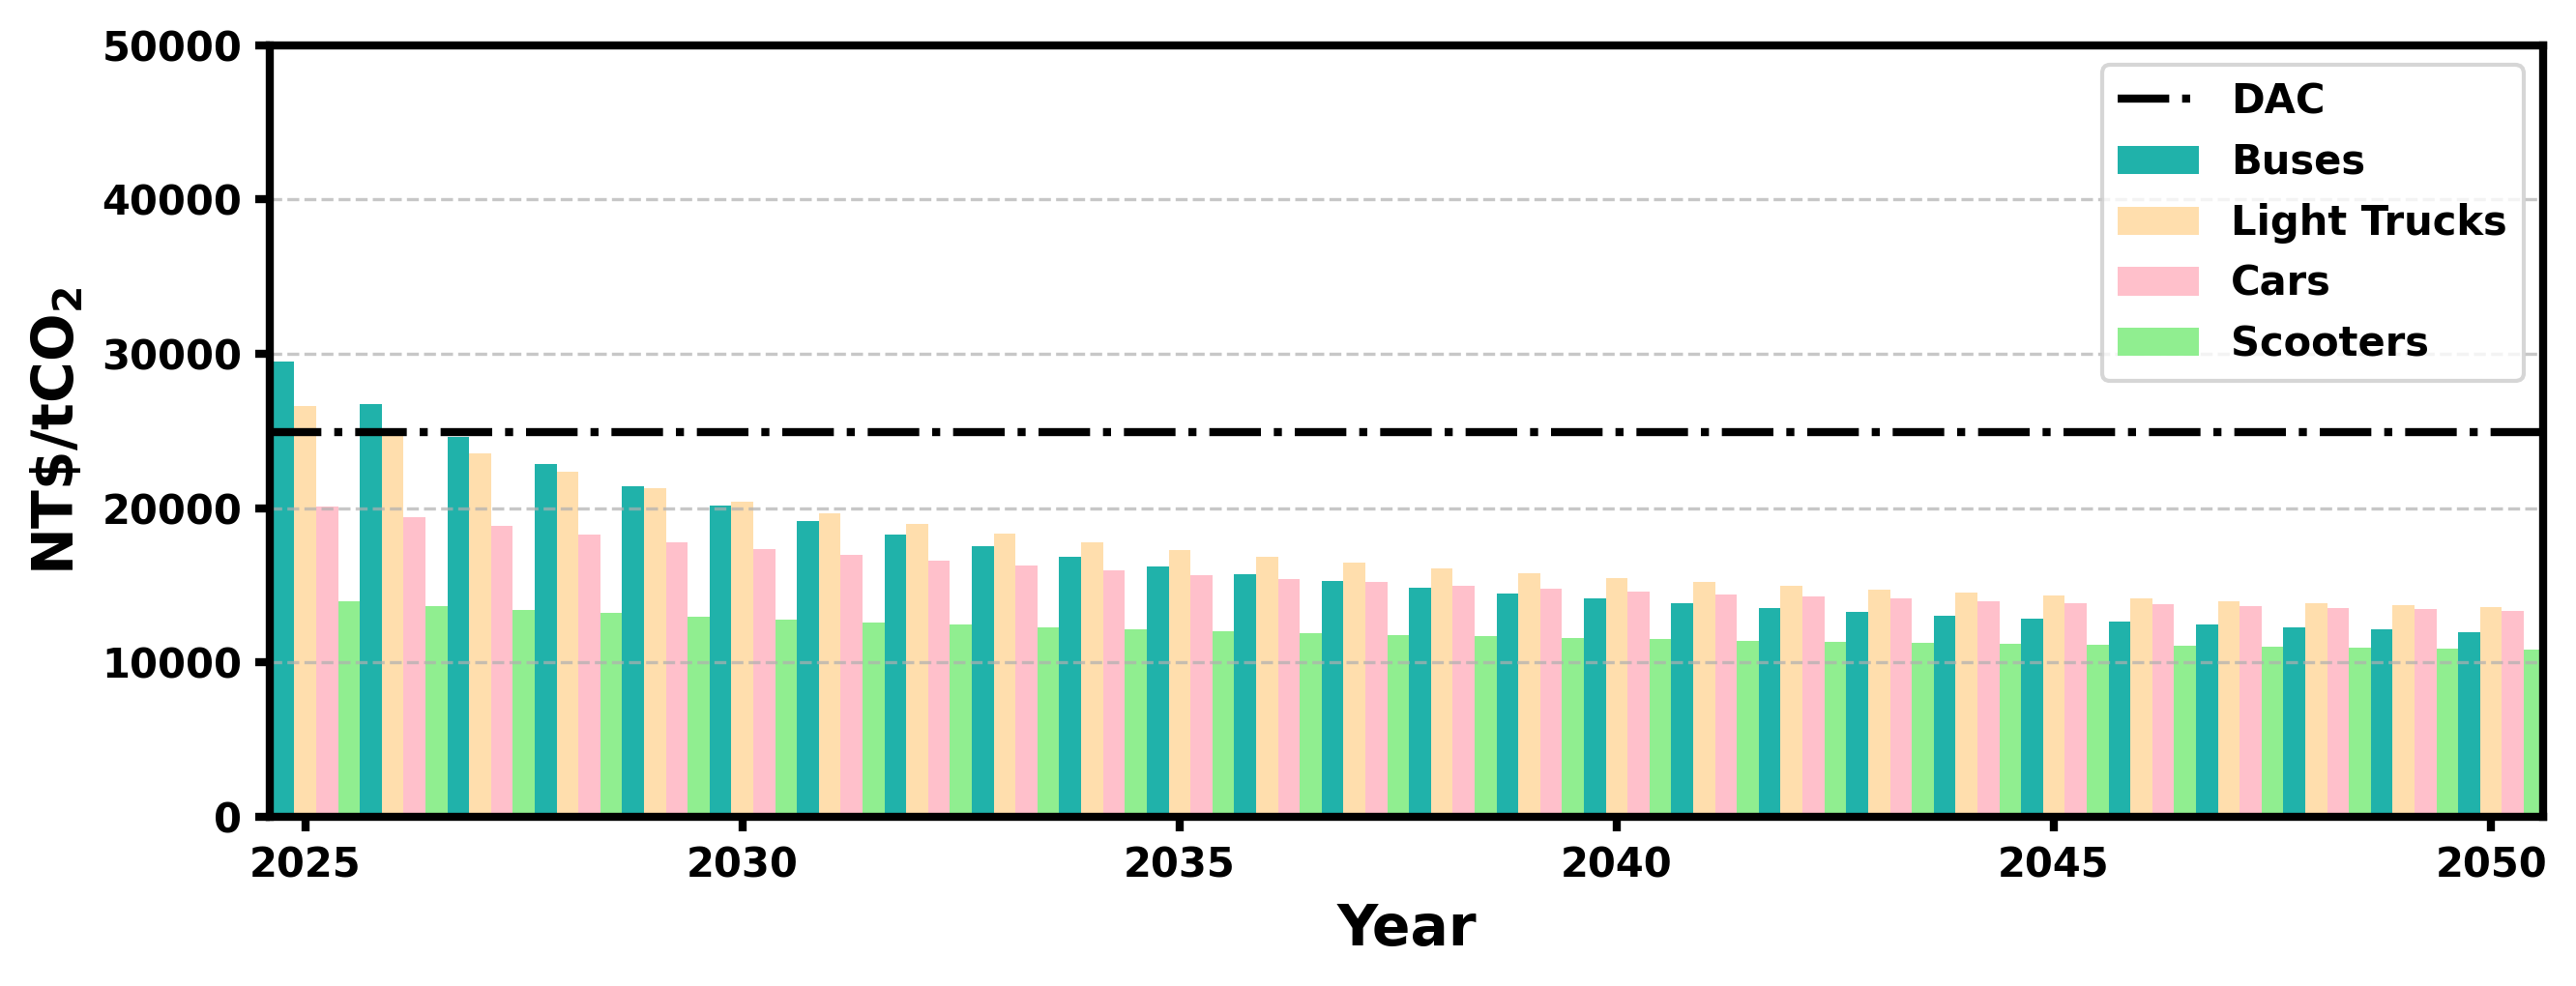

In [11]:

# Calculate cost per tCO₂ avoided
trucks_cost = np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[1]-np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[0]
cars_cost = np.array([electricity_car, capital_car, opex_car, labor_car]).sum(axis=0)[-1]-np.array([electricity_car, capital_car, opex_car, labor_car]).sum(axis=0)[0]
scooters_cost = np.array([electricity_scooter, capital_scooter, opex_scooter, labor_scooter]).sum(axis=0)[-1]-np.array([electricity_scooter, capital_scooter, opex_scooter, labor_scooter]).sum(axis=0)[0]
buses_cost = np.array([electricity_bus, capital_bus, opex_bus, labor_bus]).sum(axis=0)[-1]-np.array([electricity_bus, capital_bus, opex_bus, labor_bus]).sum(axis=0)[0]
light_trucks_cost = np.array([electricity_light_truck, capital_light_truck, opex_light_truck, labor_light_truck]).sum(axis=0)[-1]-np.array([electricity_light_truck, capital_light_truck, opex_light_truck, labor_light_truck]).sum(axis=0)[0]
ev_truck_co2_avoided = np.array(truck_emissions[0][:-1]).sum() - np.array([calculate_emission('trucks', 'electric', year_i=y) for y in year])[:,:3].sum(1)
ev_car_co2_avoided = np.array(car_emissions[0][:-1]).sum() - np.array([calculate_emission('cars', 'electric', year_i=y) for y in year])[:,:3].sum(1)
ev_scooter_co2_avoided = np.array(scooter_emissions[0][:-1]).sum() - np.array([calculate_emission('scooters', 'electric', year_i=y) for y in year])[:,:3].sum(1)
ev_bus_co2_avoided = np.array(bus_emissions[0][:-1]).sum() - np.array([calculate_emission('bus', 'electric', year_i=y) for y in year])[:,:3].sum(1)
ev_truck_light_co2_avoided = np.array(light_truck_emissions[0][:-1]).sum() - np.array([calculate_emission('trucks_light', 'electric', year_i=y) for y in year])[:,:3].sum(1)
trucks_data = np.nan_to_num(trucks_cost * 1e6 / ev_truck_co2_avoided)
cars_data = np.nan_to_num(cars_cost * 1e6 / ev_car_co2_avoided)
scooters_data = np.nan_to_num(scooters_cost * 1e6 / ev_scooter_co2_avoided)
light_trucks_data = np.nan_to_num(light_trucks_cost * 1e6 / ev_truck_light_co2_avoided)
buses_data = np.nan_to_num(buses_cost * 1e6 / ev_bus_co2_avoided)

# Filter to only years 2025–2050
mask = (year >= 2025) & (year <= 2050)
years_filtered = year[mask]
trucks_data_filtered = trucks_data[mask]
cars_data_filtered = cars_data[mask]
scooters_data_filtered = scooters_data[mask]
light_trucks_data_filtered = light_trucks_data[mask]
buses_data_filtered = buses_data[mask]

# Define bar width and positions
bar_width = 1/4
x = np.arange(len(years_filtered))

# Create figure
plt.figure(figsize=(9, 3.5), dpi=300)

# Plot grouped bars for each category
# plt.bar(x - 2*bar_width, trucks_data_filtered, width=bar_width, label='Trucks', color='silver')
plt.bar(x - bar_width, buses_data_filtered, width=bar_width, label='Buses', color='lightseagreen')
plt.bar(x, light_trucks_data_filtered, width=bar_width, label='Light Trucks', color='navajowhite')
plt.bar(x + bar_width, cars_data_filtered, width=bar_width, label='Cars', color='pink')
plt.bar(x + 2*bar_width, scooters_data_filtered, width=bar_width, label='Scooters', color='lightgreen')

# DAC cost reference line
plt.axhline(y=usd_to_ntd(800), linestyle='-.', color='black', label='DAC',linewidth=2)

#https://link.springer.com/article/10.1557/s43581-024-00091-5
# Labels and title
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('NT\$/tCO$_2$', fontsize=14, fontweight='bold')
# plt.title('Cost of CO$_2$ Emissions Avoided (2025–2050)', fontsize=14)

# X-axis ticks
plt.xticks(ticks=np.arange(0, len(years_filtered), step=5), labels=np.arange(2025, 2055, step=5))

# X-axis limits
plt.xlim(-0.4, len(x) - 0.4)
plt.ylim([0,5e4])
# Legend and grid
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tight layout and show
plt.tight_layout()
# plt.show()
plt.savefig("figs/Cost_co2_avoided_a.png", format='png')
# plt.close()

<>:50: SyntaxWarning: invalid escape sequence '\$'
<>:50: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_40446/2714796651.py:50: SyntaxWarning: invalid escape sequence '\$'
  plt.ylabel('NT\$/tCO$_2$', fontsize=14, fontweight='bold')


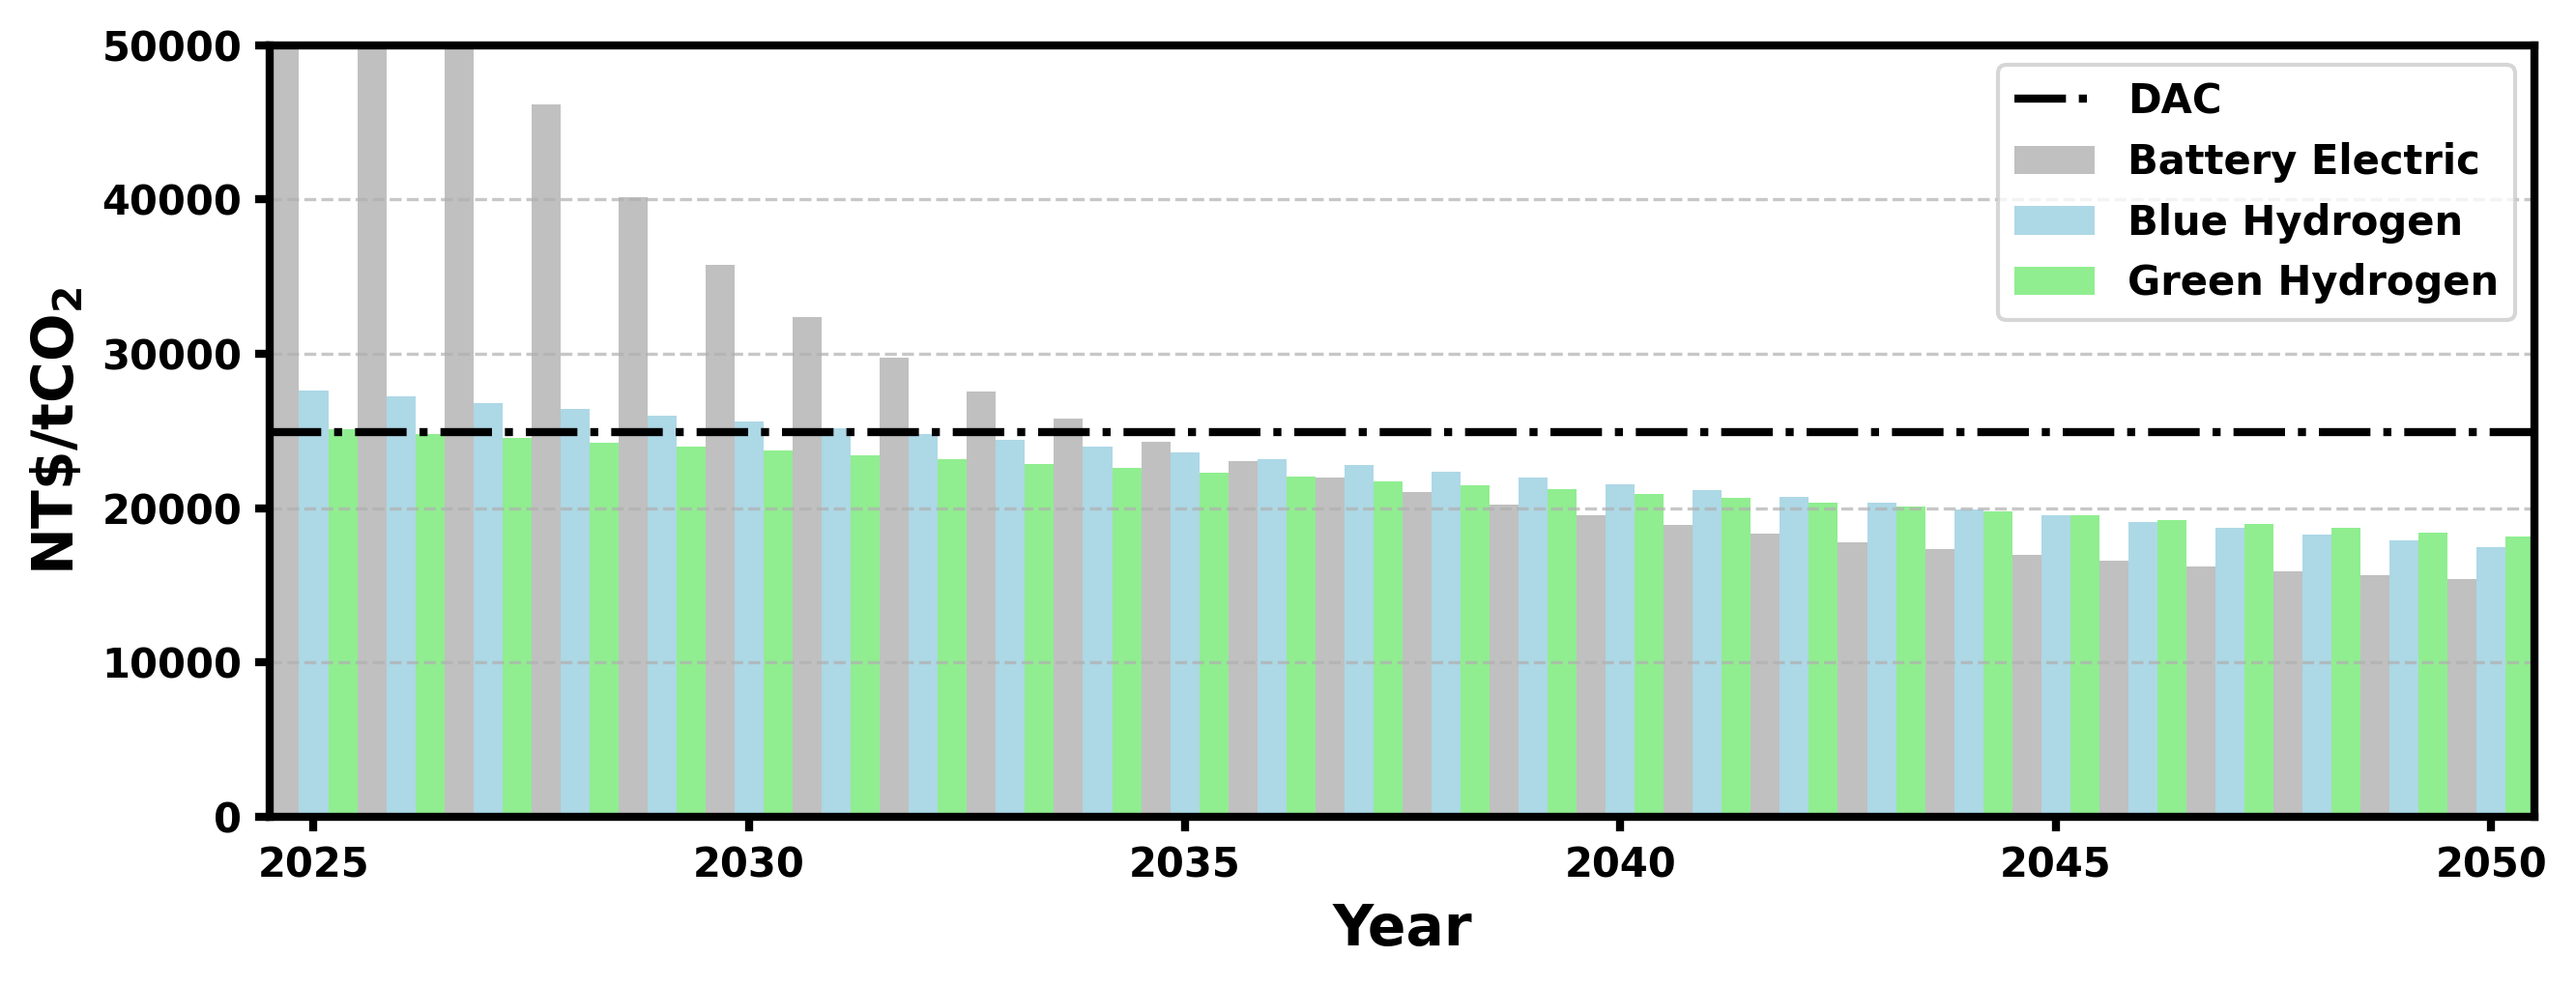

In [12]:


trucks_cost_blue_2050 = hydrogen_data_blue[0,0,-1]
trucks_cost_green_2050 = hydrogen_data_green[0,0,-1]

# Truck data
dispense_cost_low  = 8
dispense_cost_high = 11
trucks['hydrogen_low'].fuel_cost = (dispense_cost_low+1.5) * trucks['hydrogen_low'].fuel_efficiency/hydrogen_kwh_per_kg
trucks['hydrogen_high'].fuel_cost = (dispense_cost_high+2.9) * trucks['hydrogen_high'].fuel_efficiency/hydrogen_kwh_per_kg
hydrogen_data_blue_2025 = aggregate_results(trucks,['hydrogen'],'NTD')
trucks['hydrogen_low'].fuel_cost = (dispense_cost_low+3.6) * trucks['hydrogen_low'].fuel_efficiency/hydrogen_kwh_per_kg
trucks['hydrogen_high'].fuel_cost = (dispense_cost_high+7.5) * trucks['hydrogen_high'].fuel_efficiency/hydrogen_kwh_per_kg
hydrogen_data_green_2025 = aggregate_results(trucks,['hydrogen'],'NTD')

trucks_cost_blue_2025 = hydrogen_data_blue_2025[0,0,-1]
trucks_cost_green_2025 = hydrogen_data_green_2025[0,0,-1]

trucks_cost_blue = np.linspace(trucks_cost_blue_2025,trucks_cost_blue_2050,len(year))-np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[0]
trucks_cost_green = np.linspace(trucks_cost_green_2025,trucks_cost_green_2050,len(year))-np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[0]

ev_truck_co2_avoided_blue = np.array(truck_emissions[0][:-1]).sum() - np.array(truck_emissions[-1][4:6]).sum()
ev_truck_co2_avoided_green = np.array(truck_emissions[0][:-1]).sum() - np.array(truck_emissions[-1][8:10]).sum()

trucks_data_blue = np.nan_to_num(trucks_cost_blue * 1e6 / ev_truck_co2_avoided_blue)
trucks_data_green = np.nan_to_num(trucks_cost_green * 1e6 / ev_truck_co2_avoided_green)

# Filter to only years 2025–2050
mask = (year >= 2025) & (year <= 2050)
years_filtered = year[mask]
trucks_data_filtered_blue = trucks_data_blue[mask]
trucks_data_filtered_green = trucks_data_green[mask]

# Define bar width and positions
bar_width = 1/3
x = np.arange(len(years_filtered))

# Create figure
plt.figure(figsize=(9, 3.5), dpi=300)

# Plot grouped bars for each category
plt.bar(x - bar_width, trucks_data_filtered, width=bar_width, label='Battery Electric', color='silver')
plt.bar(x, trucks_data_filtered_blue, width=bar_width, label='Blue Hydrogen', color='lightblue')
plt.bar(x + bar_width, trucks_data_filtered_green, width=bar_width, label='Green Hydrogen', color='lightgreen')

# DAC cost reference line
plt.axhline(y=usd_to_ntd(800), linestyle='-.', color='black', label='DAC',linewidth=2)

#https://link.springer.com/article/10.1557/s43581-024-00091-5
# Labels and title
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('NT\$/tCO$_2$', fontsize=14, fontweight='bold')
# plt.title('Cost of CO$_2$ Emissions Avoided (2025–2050)', fontsize=14)

# X-axis ticks
plt.xticks(ticks=np.arange(0, len(years_filtered), step=5), labels=np.arange(2025, 2055, step=5))

# X-axis limits
plt.xlim(-0.5, len(x) - 0.5)
# plt.ylim([0,5e4])
# Legend and grid
plt.legend( loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim([0,5e4])

# Tight layout and show
plt.tight_layout()
# plt.show()
plt.savefig("figs/Cost_co2_avoided_b.png", format='png')



## Sensitivity analysis

In [13]:
def calculate_FC_Grid(vehicle, years, discount_rate, E_price_matrix):
    PVF_1D = 1 / (1 + discount_rate) ** np.arange(years)
    
    # 2. Reshape the 1D PVF into a 3D grid to match the E_price_matrix and years.
    #    The shape becomes (1, 1, years), which can be broadcast to (31, 31, 16).
    PVF_3D = np.broadcast_to(PVF_1D, (E_price_matrix.shape[0], E_price_matrix.shape[1], years))
    
    # 3. Calculate the costs for each year and each grid cell.
    #    E_price_matrix (2D) is automatically broadcast to (31, 31, 1) for the operation,
    #    resulting in a 3D grid of future costs.
    FC_grid = (vehicle.fuel_efficiency * E_price_matrix[:, :, np.newaxis] + vehicle.fuel_fee_rate) * PVF_3D / years
    
    # 4. Sum the costs over the time dimension (the third axis) to get the total
    #    present value cost for each cell on the grid.
    return usd_to_ntd(np.sum(FC_grid, axis=2))

def calcualate_average_TCO_Grid(vehicle,catagory,E_price):
    results = np.array([calculate_FC_Grid(vehicle[f'{catagory}_low'], years, depreciation_rate,E_price),
                        calculate_FC_Grid(vehicle[f'{catagory}_high'], years, depreciation_rate,E_price)])
    return results.mean(axis=0)

In [14]:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
electricity_prices = np.linspace(0, 0.5, 301)  # $/kWh
grid_intensities = np.linspace(0, .4, 301)    # kg CO2/kWh

# Meshgrid for contour plot
E_price, G_intensity = np.meshgrid(electricity_prices, grid_intensities)

low_eff = trucks['electric_low'].fuel_efficiency
high_eff = trucks['electric_high'].fuel_efficiency
emission_electric = truck_emissions[1][0] + G_intensity * 1000 * (low_eff+high_eff)/2 
emission = np.array(truck_emissions[0][:-1]).sum() - emission_electric
cost = calcualate_average_TCO_Grid(trucks,'electric',E_price) + np.array([capital_truck, opex_truck, labor_truck]).sum(axis=0)[1]-np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[0]

cost_per_ton = cost * 1e6 /emission

# Create figure
plt.figure(figsize=(4, 3), dpi=300)

# Mask negative values
masked_cost_per_ton = np.ma.masked_where(cost_per_ton < 0, cost_per_ton)

# Create custom colormap with gray for masked values
cmap = plt.cm.get_cmap("viridis").copy()
# cmap.set_bad(color='lightgray')  # Use lightgray for better visibility

# Create a version where negative values are set to a large negative number for gray plotting
cost_for_gray = np.where(cost_per_ton < 0, -999999, np.nan)
cost_for_color = np.where(cost_per_ton >= 0, cost_per_ton, np.nan)

# Plot negative regions in gray
# plt.contourf(E_price, G_intensity, cost_for_gray, levels=[-1000000, -1], colors=['gray'])

# Plot positive values with viridis colormap
cp = plt.contourf(E_price, G_intensity, cost_for_color, levels=30, cmap=cmap, extend='max')

# Add colorbar
cbar = plt.colorbar(cp)
cbar.set_label("Cost of CO₂ avoided (NT$/tCO₂)")

plt.text(0.014, 0.985, ' '*98,rotation=90, fontsize=5, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

plt.xlabel("Retail electricity price ($/kWh)")
plt.ylabel("Grid carbon\nintensity (kgCO₂/kWh)")
plt.tight_layout()
# plt.show()
plt.savefig("figs/contour_electricity.png", format='png')


/tmp/ipykernel_40446/3785487557.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


In [15]:
E_price[np.isnan(cost_for_color)].max()

np.float64(0.028333333333333335)

In [16]:

electricity_prices = np.linspace(.8, 15, 301)  # $/kWh
grid_intensities = np.linspace(0,10, 301)    # kg CO2/kWh

# Meshgrid for contour plot
E_price, G_intensity = np.meshgrid(electricity_prices, grid_intensities)

low_eff = trucks['hydrogen_low'].fuel_efficiency
high_eff = trucks['hydrogen_high'].fuel_efficiency
emission_electric = truck_emissions[-1][0] + G_intensity / hydrogen_kwh_per_kg * 1000 * (low_eff+high_eff)/2 
emission = np.array(truck_emissions[0][:-1]).sum() - emission_electric
cost = calcualate_average_TCO_Grid(trucks,'hydrogen',E_price/hydrogen_kwh_per_kg) + np.array([capital_truck, opex_truck, labor_truck]).sum(axis=0)[-1]-np.array([electricity_truck, capital_truck, opex_truck, labor_truck]).sum(axis=0)[0]

cost_per_ton = cost * 1e6 /emission

# Create figure
plt.figure(figsize=(4, 3), dpi=300)

# Mask negative values
masked_cost_per_ton = np.ma.masked_where(cost_per_ton < 0, cost_per_ton)

# Create custom colormap with gray for masked values
cmap = plt.cm.get_cmap("viridis").copy()

# Create a version where negative values are set to a large negative number for gray plotting
cost_for_gray = np.where(cost_per_ton < 0, -999999, np.nan)
cost_for_color = np.where(cost_per_ton >= 0, cost_per_ton, np.nan)

# Plot negative regions in gray
# plt.contourf(E_price, G_intensity, cost_for_gray, levels=[-1000000, -1], colors=['gray'])

# Plot positive values with viridis colormap
cp = plt.contourf(E_price, G_intensity, cost_for_color, levels=30, cmap=cmap, extend='max')
# plt.plot(2.17+grid_intensities*0,grid_intensities,'.')
# Add colorbar
cbar = plt.colorbar(cp)
cbar.set_label("Cost of CO₂ avoided (NT$/tCO₂)")

plt.text(0.02, 0.98, 'Gray: saving money + emissions',rotation=90, fontsize=9.4, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

plt.xlabel("Hydrogen pump price ($/kg)")
plt.ylabel("Hydrogen production\nemissions (kgCO₂/kg)")
plt.tight_layout()
# plt.show()
plt.savefig("figs/contour_hydrogen.png", format='png')


/tmp/ipykernel_40446/497003147.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


In [17]:
E_price[np.isnan(cost_for_color)].max()#+E_price.min()

np.float64(2.1726666666666667)

In [18]:

electricity_prices = np.linspace(0., 0.5, 31)  # $/kWh
grid_intensities = np.linspace(0, .45, 31)    # kg CO2/kWh

# Meshgrid for contour plot
E_price, G_intensity = np.meshgrid(electricity_prices, grid_intensities)

low_eff = cars['electric_low'].fuel_efficiency
high_eff = cars['electric_high'].fuel_efficiency
emission_electric = car_emissions[-1][0] + G_intensity * 1000 * (low_eff+high_eff)/2 
emission = np.array(car_emissions[0][:-1]).sum() - emission_electric
cost = calcualate_average_TCO_Grid(cars,'electric',E_price) + np.array([capital_car, opex_car, labor_car]).sum(axis=0)[-1]-np.array([electricity_car, capital_car, opex_car, labor_car]).sum(axis=0)[0]

cost_per_ton = cost * 1e6 /emission

# Create figure
plt.figure(figsize=(4, 3), dpi=300)

# Mask negative values
masked_cost_per_ton = np.ma.masked_where(cost_per_ton < 0, cost_per_ton)

# Create custom colormap with gray for masked values
cmap = plt.cm.get_cmap("viridis").copy()
# cmap.set_bad(color='lightgray')  # Use lightgray for better visibility

# Create a version where negative values are set to a large negative number for gray plotting
cost_for_gray = np.where(cost_per_ton < 0, -999999, np.nan)
cost_for_color = np.where(cost_per_ton >= 0, cost_per_ton, np.nan)

# Plot negative regions in gray
# plt.contourf(E_price, G_intensity, cost_for_gray, levels=[-1000000, -1], colors=['gray'])

# Plot positive values with viridis colormap
cp = plt.contourf(E_price, G_intensity, cost_for_color, levels=30, cmap=cmap, extend='max')

# Add colorbar
cbar = plt.colorbar(cp)
cbar.set_label("Cost of CO₂ avoided (NT$/tCO₂)")

plt.xlabel("Electricity price ($/kWh)")
plt.ylabel("Grid carbon intensity (kgCO₂/kWh)")
plt.tight_layout()
# plt.show()

/tmp/ipykernel_40446/949753923.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis").copy()


## Calculate and plot total emissions/energy

In [19]:

plt.rcParams.update({
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'axes.linewidth': 2,
})

year_r = [2020,2030,2035,2040,2050]
def calculate_demand(year, Grid_intensity, year_r, target_r, sales, fleet, offset):
    target_e = np.interp(year,year_r,target_r)*sales
    target_e_c = []
    temp=offset
    for i in range(len(target_e)):
        temp=temp+target_e[i]
        if temp<fleet:
            temp=temp
        else:
            temp = fleet
        target_e_c.append(temp)
    target_e_c = np.array(target_e_c)
    target_IC = fleet-target_e_c
    return target_e_c, target_IC

target_r = [0,0,0,0.3,0.6]

eff_trucks = (trucks['electric_low'].fuel_efficiency + trucks['electric_high'].fuel_efficiency)/2
sales_trucks = 9700
fleet_trucks = 167088
VKT_trucks = 33388
offset_trucks = 0
target_e_c, target_IC = calculate_demand(year, Grid_intensity, year_r, target_r, sales_trucks, 
                                         fleet_trucks, offset_trucks)

EI_trucks =((trucks['diesel_low'].fuel_efficiency + trucks['diesel_high'].fuel_efficiency)/2)/diesel_kwh_per_liter * kg_co2_per_L_diesel
diesel_truck = EI_trucks*fleet_trucks*VKT_trucks/1e9
bet = (Grid_intensity*eff_trucks)*fleet_trucks*VKT_trucks/1e9
ice_trucks = target_IC/fleet_trucks*diesel_truck
ev_trucks = bet*target_e_c/fleet_trucks
target_trucks = ice_trucks + ev_trucks
ev_trucks_cost = target_e_c*electric_truck_tco*VKT_trucks/1e9
energy_trucks = target_e_c * eff_trucks * VKT_trucks/1e9

target_r = [0,.3,.6,1,1]
eff_cars = (cars['electric_low'].fuel_efficiency + cars['electric_high'].fuel_efficiency)/2
sales_cars = 457837
fleet_cars = 7122350
VKT_cars = 12179
offset_cars = 0
target_e_c, target_IC = calculate_demand(year, Grid_intensity, year_r, target_r, sales_cars,
                                         fleet_cars, offset_cars)
target_ch = target_e_c[:21]
EI_cars =((cars['gasoline_low'].fuel_efficiency + cars['gasoline_high'].fuel_efficiency)/2)/gasoline_kwh_per_liter * kg_co2_per_L_gasoline
gasoline_car = EI_cars*fleet_cars*VKT_cars/1e9
bev = (np.array(Grid_intensity)*eff_cars)*fleet_cars*VKT_cars/1e9
ice_cars = target_IC/fleet_cars*gasoline_car
ev_cars = bev*target_e_c/fleet_cars
target_cars = ice_cars + ev_cars
ev_cars_cost = target_e_c*electric_car_tco*VKT_cars/1e9
energy_cars = target_e_c * ((cars['electric_low'].fuel_efficiency + cars['electric_high'].fuel_efficiency)/2) * VKT_cars /1e9


target_r = [0,.35,.7,1,1]
sales_scooters = 695670
fleet_scooters = 14611708
VKT_scooters = 6400
offset_scooters = 546438
realistic_e_c = (np.arange(2020,2051)-2020)*(775397-546438)/4+546438
realistic_IC = fleet_scooters-realistic_e_c
year_r = [2020,2030,2035,2040,2050]
eff_e_scooters = (scooters['electric_low'].fuel_efficiency + scooters['electric_high'].fuel_efficiency)/2
EI_scooters = (scooters['gasoline_low'].fuel_efficiency + scooters['gasoline_high'].fuel_efficiency)/2/gasoline_kwh_per_liter * kg_co2_per_L_gasoline

target_e_c, target_IC = calculate_demand(year, Grid_intensity, year_r, target_r, sales_scooters,
                                         fleet_scooters, offset_scooters)

gasoline_scooter = EI_scooters*fleet_scooters*VKT_scooters/1e9
e_scooter = (np.array(Grid_intensity)*eff_e_scooters)*fleet_scooters*VKT_scooters/1e9
scooter_interp = np.interp(np.arange(2020,2051),year,e_scooter)

ice_scooters = target_IC/fleet_scooters*gasoline_scooter
ev_scooters = scooter_interp*target_e_c/fleet_scooters
target_scooters = ice_scooters+ev_scooters
ev_scooters_cost = target_e_c*electric_scooter_tco*VKT_scooters/1e9
energy_scooters = target_e_c * ((scooters['electric_low'].fuel_efficiency + scooters['electric_high'].fuel_efficiency)/2) * VKT_scooters/1e9

target_r = [0,0,.3,.6,.6]

eff_trucks_light = (trucks_light['electric_low'].fuel_efficiency + trucks_light['electric_high'].fuel_efficiency)/2 # 1.2
sales_trucks_light = 71380
fleet_trucks_light = 941000
VKT_trucks_light = 11509
offset_trucks_light = 0
target_e_c, target_IC = calculate_demand(year, Grid_intensity, year_r, target_r, sales_trucks_light, 
                                         fleet_trucks_light, offset_trucks_light)

EI_trucks_light =((trucks_light['gasoline_low'].fuel_efficiency + trucks_light['gasoline_high'].fuel_efficiency)/2)/gasoline_kwh_per_liter * kg_co2_per_L_gasoline

diesel_truck_light = EI_trucks_light*fleet_trucks_light*VKT_trucks_light/1e9
bet = (Grid_intensity*eff_trucks_light)*fleet_trucks_light*VKT_trucks_light/1e9
ice_trucks_light = target_IC/fleet_trucks_light*diesel_truck_light
ev_trucks_light = bet*target_e_c/fleet_trucks_light
target_trucks_light = ice_trucks_light + ev_trucks_light
ev_trucks_light_cost = target_e_c*electric_lt_tco*VKT_trucks_light/1e9
energy_trucks_light = target_e_c * ((trucks_light['electric_low'].fuel_efficiency + trucks_light['electric_high'].fuel_efficiency)/2) * VKT_trucks_light/1e9

target_r = [0,1,1,1,1]
eff_bus = (bus['electric_low'].fuel_efficiency + bus['electric_high'].fuel_efficiency)/2 
sales_bus = 5121
fleet_bus = 30127
VKT_bus = 58793
offset_bus = 0
target_e_c, target_IC = calculate_demand(year, Grid_intensity, year_r, target_r, sales_bus, 
                                         fleet_bus, offset_bus)

EI_bus =((bus['diesel_low'].fuel_efficiency + bus['diesel_high'].fuel_efficiency)/2)/diesel_kwh_per_liter * kg_co2_per_L_diesel

diesel_bus = EI_bus*fleet_bus*VKT_bus/1e9
bet = (Grid_intensity*eff_bus)*fleet_bus*VKT_bus/1e9
ice_bus = target_IC/fleet_bus*diesel_bus
ev_bus = bet*target_e_c/fleet_bus
target_bus = ice_bus + ev_bus
ev_bus_cost = target_e_c*electric_bus_tco*VKT_bus/1e9
energy_bus = target_e_c * ((bus['electric_low'].fuel_efficiency + bus['electric_high'].fuel_efficiency)/2) * VKT_bus/1e9
prod_emm_bus = np.array([target_e_c, target_IC])
# Stack the emissions
plt.figure(figsize=(8.5, 3.5), dpi=300)

# Base layers
plt.bar(year, ice_trucks, label='ICE Trucks', color='brown')
plt.bar(year, ev_trucks, bottom=ice_trucks, label='EV Trucks', color='lightblue')
plt.bar(year, ice_cars, bottom=ice_trucks + ev_trucks, label='ICE Cars', color='red')
plt.bar(year, ev_cars, bottom=ice_trucks + ev_trucks + ice_cars, label='EV Cars', color='pink')
plt.bar(year, ice_scooters, bottom=ice_trucks + ev_trucks + ice_cars + ev_cars, label='ICE Scooters', color='purple')
plt.bar(year, ev_scooters, bottom=ice_trucks + ev_trucks + ice_cars + ev_cars + ice_scooters, label='EV Scooters', color='lightgreen')

# Light trucks
bottom_ice_truck_light = ice_trucks + ev_trucks + ice_cars + ev_cars + ice_scooters + ev_scooters
plt.bar(year, ice_trucks_light, bottom=bottom_ice_truck_light, label='ICE Light Trucks', color='orange')

bottom_ev_truck_light = bottom_ice_truck_light + ice_trucks_light
plt.bar(year, ev_trucks_light, bottom=bottom_ev_truck_light, label='EV Light Trucks', color='navajowhite')

# Buses
bottom_ice_bus = bottom_ev_truck_light + ev_trucks_light
plt.bar(year, ice_bus, bottom=bottom_ice_bus, label='ICE Buses', color='darkgreen')

bottom_ev_bus = bottom_ice_bus + ice_bus
plt.bar(year, ev_bus, bottom=bottom_ev_bus, label='EV Buses', color='lightseagreen')

# Target line
plt.plot(np.arange(1, 10000), np.arange(1, 10000)*0 + 3.3, '-.', label='2050 Goal', color='black')

# Labels and title
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('MMt CO$_2$eq', fontsize=14, fontweight='bold')
# plt.title('Annual Tank-to-Wheel Emissions', fontsize=14)

# Legend outside
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim([0, 38])
plt.xlim([2020 - .5, 2050 + .5])
plt.tight_layout()

# Show plot
# plt.show()
plt.savefig("figs/total_emissions.png", format='png')

plt.figure(figsize=(8.5, 3.5), dpi=300)

# Base layers
plt.bar(year, energy_cars, label='Cars', color='lightblue')
plt.bar(year, energy_scooters, bottom=energy_cars, label='Scooters', color='pink')
plt.bar(year, energy_trucks_light, bottom=energy_cars + energy_scooters, label='Light Trucks', color='lightgreen')

# # Light trucks
bottom_bus = energy_cars + energy_scooters + energy_trucks_light
plt.bar(year,energy_bus, bottom=bottom_bus, label='Buses', color='navajowhite')

# # Buses
bottom_trucks = bottom_bus + energy_bus
plt.bar(year, energy_trucks, bottom=bottom_trucks, label='Trucks', color='lightseagreen')

# Labels and title
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Electricity demand (TWh)', fontsize=14, fontweight='bold')
# plt.title('Emissions Avoided by Electrification', fontsize=14)

# Legend outside
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Axes limits
plt.xlim([2025 - 0.5, 2050 + 0.5])
plt.tight_layout()

# Show plot
# plt.show()
plt.savefig("figs/energy_demand.png", format='png')



## Calculate and plot charging needs

In [20]:
year = np.arange(2020, 2041)

# Calculate the two trend lines (in thousands of ports)
eu_recommendation = target_ch / 10 / 1000
china_japan_trend = target_ch / 7 / 1000

# Cost assumptions
cost_level2 = 7200   # USD/port
cost_level3 = 50000  # USD/port
share_level2 = 0.75
share_level3 = 0.25

avg_cost = share_level2 * cost_level2 + share_level3 * cost_level3  # weighted avg cost

# Convert number of ports (thousands) to cost (in billions USD)
def ports_to_cost(ports_thousands):
    ports = ports_thousands * 1000  # back to absolute number
    return ports * avg_cost / 1e9  # cost in billions

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 5), dpi=150)

# Left y-axis (charging ports)
ax1.plot(year, eu_recommendation, label='EU Recommendation', linestyle='--', color='blue', linewidth=2)
ax1.plot(year, china_japan_trend, label='China/Japan Trend', linestyle='-', color='green', linewidth=2)
ax1.plot(2024, 9.770, 'o', label='2024 Observed', color='red', markersize=8)

ax1.set_xlim([2020, 2040])
ax1.set_ylim([0, 500])
ax1.set_xticks(np.arange(2020, 2041, 2))
ax1.set_xlabel("Year", fontsize=18)
ax1.set_ylabel("Public EV Charging\nPorts (thousand)", fontsize=18)
ax1.tick_params(axis='both', labelsize=12)
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.6)

# Right y-axis (investment cost)
ax2 = ax1.twinx()
yticks_ports = ax1.get_yticks()
yticks_cost = ports_to_cost(yticks_ports)
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(yticks_ports)
ax2.set_yticklabels([f"${c:.1f}B" for c in yticks_cost], fontsize=14)
ax2.set_ylabel("Investment Cost\n(billion USD)", fontsize=18)

plt.tight_layout()
# plt.show()

plt.savefig("figs/chargers.png", format='png')



## Calculate TCO vs Emissions

In [21]:
df_lisa = pd.read_csv('data/lisa_cars.csv')
# Set style
sns.set(font_scale=1.5)
# Compute type averages / and replace with ours
df_avg = df_lisa.groupby("Type", as_index=False)[["Total Cost", "Total Emission"]].mean()
df_avg.loc[2,'Total Emission'] = np.array(car_emissions[0][:-1]).sum()/1000
df_avg.loc[2,'Total Cost'] = car_results[0][0][-1]
# Get ICEV average
icev_avg = df_avg[df_avg["Type"] == "ICEV"].iloc[0]
icev_cost = icev_avg["Total Cost"]
icev_emission = icev_avg["Total Emission"]

# Calculate CO₂ abatement cost for BEVs
df_bev = df_lisa[df_lisa["Type"] == "BEV"].copy()
df_bev["CO2_abatement_cost"] = (1000*
    (df_bev["Total Cost"] - icev_cost) /
    (icev_emission - df_bev["Total Emission"])) / 10000


# df_bev = df_bev[(df_bev['CO2_abatement_cost']<700)]
# Separate positive and negative abatement cost BEVs
df_bev_pos = df_bev[df_bev["CO2_abatement_cost"] > 1]
df_bev_neg = df_bev[df_bev["CO2_abatement_cost"] <= 1]

# Define grid over total cost and emissions
x = np.linspace(df_bev["Total Cost"].min()-3, df_bev["Total Cost"].max()+6, 200)
y = np.linspace(df_bev["Total Emission"].min()-.3, df_bev["Total Emission"].max()+.7, 200)
X, Y = np.meshgrid(x, y)

# --- Calculate abatement cost surface ---
baseline_cost = icev_avg["Total Cost"]       # avg ICE cost (NTD/km)
baseline_emission = icev_avg["Total Emission"]  # avg ICE emissions (kg/km)

Z = (X - baseline_cost) / (baseline_emission - Y) * 1000 / 10000  # 10k NTD per tCO2

# --- Plot ---
plt.figure(figsize=(11, 6), dpi=300)

# Shade regions
plt.contourf(X, Y, Z, levels=[-1e6, usd_to_ntd(150)/ 10000], colors=["green"], alpha=0.1)    # Reasonable zone
plt.contourf(X, Y, Z, levels=[usd_to_ntd(150)/ 10000, 1e8/ 10000], colors=["red"], alpha=0.05)      # Expensive zone

# --- Define marker styles for each vehicle class ---
markers = {
    "Sedan": "o",
    "SUV": "s",
    "Hatchback": "D",
    "Wagons": "^"
}
default_marker = "o"

# --- Scatter by class ---
for vehicle_class, group in df_bev_pos.groupby("Class"):
    plt.scatter(
        group["Total Cost"],
        group["Total Emission"],
        c=group["CO2_abatement_cost"],
        cmap="viridis",
        s=70,
        edgecolor="black",
        marker=markers.get(vehicle_class, default_marker),
        label=vehicle_class
    )

# Negative/near-zero abatement cost (open symbols)
for vehicle_class, group in df_bev_neg.groupby("Class"):
    plt.scatter(
        group["Total Cost"],
        group["Total Emission"],
        facecolors="none",
        edgecolors="black",
        s=70,
        linewidths=1.2,
        marker=markers.get(vehicle_class, default_marker),
        label=f"{vehicle_class} (neg. cost)"
    )

# --- Annotate edge cases only ---
edge_cases = pd.concat([
    df_bev.loc[[df_bev["Total Cost"].idxmin()]],
    df_bev.loc[[df_bev["Total Cost"].idxmax()]],
    df_bev.loc[[df_bev["Total Emission"].idxmin()]],
    df_bev.loc[[df_bev["Total Emission"].idxmax()]],
]).drop_duplicates()

for _, row in edge_cases.iterrows():
    if row["Total Emission"] > .2:
        plt.text(
            row["Total Cost"],
            row["Total Emission"] - 0.004,  # slight offset
            f"{row['Model']} {row['Trim']}",
            fontsize=9,
            ha="center",
            fontweight="bold"
        )
    else:
        plt.text(
            row["Total Cost"],
            row["Total Emission"] - 0.007,  # slight offset
            f"{row['Model']} \n{row['Trim']}",
            fontsize=9,
            ha="center",
            fontweight="bold"
        )

# Add corner labels
plt.text(0.01, 0.98, "Good", transform=plt.gca().transAxes,
         fontsize=18, fontweight="bold", color="green", ha="left", va="top")

plt.text(0.99, 0.98, "Expensive", transform=plt.gca().transAxes,
         fontsize=18, fontweight="bold", color="red", ha="right", va="top")

# Add colorbar for abatement cost
sc = plt.cm.ScalarMappable(cmap="viridis")
sc.set_array(df_bev_pos["CO2_abatement_cost"])
cbar = plt.colorbar(sc)
cbar.set_label("Cost of CO$_2$ avoided (10KNT\$/tCO$_2$)", fontsize=20)

# Labels
plt.xlabel("Total Cost of Ownership (NT\$/km)")
plt.ylabel("Total Emissions (kgCO$_2$eq/km)")

plt.xlim([3, 42])
plt.ylim([.12, .23])
plt.legend(frameon=True, loc="lower right", fontsize=14)
plt.tight_layout()
# plt.show()

plt.savefig("figs/LCEvsTCO.png", format='png')



<>:117: SyntaxWarning: invalid escape sequence '\$'
<>:120: SyntaxWarning: invalid escape sequence '\$'
<>:117: SyntaxWarning: invalid escape sequence '\$'
<>:120: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_40446/3091719862.py:117: SyntaxWarning: invalid escape sequence '\$'
  cbar.set_label("Cost of CO$_2$ avoided (10KNT\$/tCO$_2$)", fontsize=20)
/tmp/ipykernel_40446/3091719862.py:120: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel("Total Cost of Ownership (NT\$/km)")


/tmp/ipykernel_40446/3091719862.py:117: SyntaxWarning: invalid escape sequence '\$'
  cbar.set_label("Cost of CO$_2$ avoided (10KNT\$/tCO$_2$)", fontsize=20)
/tmp/ipykernel_40446/3091719862.py:120: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel("Total Cost of Ownership (NT\$/km)")


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.